In [117]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [3]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [6]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [7]:
PROCESSED_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 
    'results', 'stats', 'gaze', 'inverted_enc')

### Training

In [8]:
from utils.distrib import color_smart_diff, color_smart_diff_outer
from scipy.spatial.distance import cdist

def deg_signed_diff(d1, epoch=180):
    d2 = - np.sign(d1) * (epoch - np.abs(d1))
    mask = np.abs(d1) < np.abs(d2)
    d = mask * d1 + (~mask) * d2
    # finally, convert 90 to -90
    half_epoch = epoch // 2
    mask_90 = d == half_epoch
    d = mask_90 * (-half_epoch) + (~mask_90) * d
    return d


class DistFunctions:
    """ define all distance function """
    @classmethod
    def diff(cls, x1, x2, dist_name, pairwise):
        if dist_name == 'cos':
            return cls.cos_diff(x1, x2, pairwise)
        elif dist_name == 'rad':
            return cls.rad_diff(x1, x2, pairwise)
        elif dist_name == 'deg':
            return cls.deg_diff(x1, x2, pairwise)
        elif dist_name == 'euc':
            return cls.euclidean_diff(x1, x2, pairwise)
        else:
            raise NotImplementedError(f'Unknown distance {dist_name}')

    @classmethod
    def cos_diff(cls, x1, x2, pairwise):
        x1 = x1 / np.linalg.norm(x1, axis=-1, keepdims=True)
        x2 = x2 / np.linalg.norm(x2, axis=-1, keepdims=True)
        if pairwise:
            dists = cdist(x1, x2, metric='cosine')
        else:
            similarity = np.sum(x1 * x2, axis=-1)
            dists = 1 - similarity
        return dists
    
    @classmethod
    def euclidean_diff(cls, x1, x2, pairwise):
        if pairwise:
            dists = cdist(x1, x2, metric='euclidean')
        else:
            diffs = x1 - x2
            dists = np.linalg.norm(diffs, axis=-1)
        return dists
    
    @classmethod
    def deg_diff(cls, x1, x2, pairwise):
        if pairwise:
            assert len(x2.shape) == 1
            x1 = x1[..., np.newaxis]
            d1 = x1 - x2 # expand last dim
        else:
            d1 = x1 - x2 # elementwise

        # convert dists to degree dists
        deg_diffs = np.abs(deg_signed_diff(d1))
        return deg_diffs
    
    @classmethod
    def rad_diff(cls, x1, x2, pairwise):
        dists = np.abs(cls.deg_diff(x1, x2, pairwise))      
        dists = np.deg2rad(dists)
        return dists

In [9]:
from scipy.ndimage import zoom

class FeatureDowngrade:
    def __init__(self, params):
        self.params = params

    def get_converted_features(self, Xs):
        new_features = []
        # 0d
        if '0d' in self.params:
            d0_features = self.get_0d(Xs)
            new_features.append(d0_features)
        #1d
        if '1d' in self.params:
            d1_features = self.shrink_1d(Xs)
            new_features.append(d1_features)
        #2d
        if '2d' in self.params:
            d2_features = self.shrink_2d(Xs)
            new_features.append(d2_features)
        new_features = np.concatenate(new_features, axis=-1)
        return new_features

    def get_0d(self, Xs):
        d0_params = self.params['0d']
        d0_features = Xs[..., d0_params['old']]
        return d0_features

    def shrink_1d(self, Xs):
        d1_params = self.params['1d']
        d1_old = Xs[..., d1_params['old']]
        d1_new = d1_old.copy()
        d1_shrink_ratio = d1_params.get('zoom_ratio', None)
        if d1_shrink_ratio is None:
            return d1_new
        else:
            d1_shrink_ratio_list = np.ones(len(d1_new.shape))
            d1_shrink_ratio_list[-1] = d1_shrink_ratio
            d1_new = zoom(d1_new, 
                zoom=d1_shrink_ratio_list, mode='wrap', order=1)
            return d1_new

    def shrink_2d(self, Xs):
        d2_params = self.params['2d']
        d2_old = Xs[..., d2_params['old']]
        d2_new = d2_old.copy()
        d2_shrink_ratio = d2_params.get('zoom_ratio', None)
        if d2_shrink_ratio is None:
            return d2_new
        else:
            # reformat d2
            H, W = d2_params['H'], d2_params['W']
            original_shape = d2_new.shape
            new_shape = (*original_shape[:-1], H, W)
            d2_new = d2_new.reshape(new_shape)

            # zoom
            d2_shrink_ratio_list = np.ones(len(d2_new.shape))
            d2_shrink_ratio_list[-2:] = d2_shrink_ratio
            d2_new = zoom(d2_new, zoom=d2_shrink_ratio_list, mode='wrap', order=1)

            # flatten
            new_shape = (*original_shape[:-1], d2_new.shape[-2] * d2_new.shape[-1])
            d2_new = d2_new.reshape(new_shape)

            return d2_new

class ForwardModel:
    def __init__(self, feature_conversion_params, n_channels):
        self.feature_conversion = FeatureDowngrade(feature_conversion_params)
        # create channels and channel centers
        self.n_channels = n_channels
        self.channel_bins = np.linspace(0, 180, n_channels+1)
        self.channel_cenetrs = (self.channel_bins[1:] + self.channel_bins[:-1]) / 2

    def raw_ys_to_channel_weights(self, ys, sharpness):
        # convert first to radian differece
        rad_diffs = DistFunctions.diff(
            ys, self.channel_cenetrs, 
            dist_name='rad', pairwise=True)
        # rad diffs to weights
        weights = np.exp(sharpness * np.cos(rad_diffs))
        # normalize
        weights = weights / np.sum(weights, axis=-1, keepdims=True)
        return weights

    def convert_xinputs(self, Xs):
        Xs = self.feature_conversion.get_converted_features(Xs)
        return Xs

    def get_channel_patterns(self, Xs, ys, item_weights, sharpness):
        # convert xs
        Xs = self.convert_xinputs(Xs)
        # get the channel weights
        ys = self.raw_ys_to_channel_weights(ys, sharpness)
        # get the total weights
        ys = item_weights[..., None] * ys
        ys = np.sum(ys, axis=-2) # across items
        ys = ys / np.sum(ys, axis=-1, keepdims=True) # normalize
        # least square
        C_hat = np.linalg.pinv(ys.T @ ys) @ ys.T @ Xs
        return Xs, ys, C_hat
        
    def find_best_y_transform(self, Xs, ys, item_weights, sharpness_range, x_dist_func, x_thresh):
        # find the best y transform
        best_sharpness = None
        best_loss = np.inf
        for sharpness in sharpness_range:
            Xs_test, ys_test, C_hat_test = self.get_channel_patterns(
                Xs, ys, item_weights, sharpness)
            Xs_pred = ys_test @ C_hat_test
            # first check if the range is ok
            x_outlier_ratio = np.mean((Xs_pred > x_thresh) | (Xs_pred < -x_thresh))
            loss = DistFunctions.diff(
                Xs_pred, Xs_test, x_dist_func, pairwise=False)
            loss = np.mean(loss)
            print(f'sharpness {sharpness:.2f} loss {loss:.6f} (invalid: {x_outlier_ratio:.2f})')
            if loss < best_loss:
                best_loss = loss
                best_sharpness = sharpness

        return best_sharpness, best_loss
    
    def predict(self, Xs, C_hat):
        Xs = self.convert_xinputs(Xs)
        ys = Xs @ C_hat.T @ np.linalg.pinv(C_hat @ C_hat.T)
        return Xs, ys

### Get Xs and Ys

### Find best sharpness value

In [10]:
d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [11]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [12]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

#### ISI phase best sharpness

In [13]:
def reformat_all_loaded(phase, stim_names, cond_lmb):
    all_xs, all_ys, all_dfs, all_tags = [], [], [], []
    for subj in all_subjs:
        features, behavior_df = load_subject_time_feature(subj, phase)
        mask = cond_lmb(behavior_df) if cond_lmb is not None else np.ones(len(behavior_df), dtype=bool)
        features = features[mask]
        behavior_df = behavior_df[mask]
        behavior_ys = behavior_df[stim_names].values
        all_xs.append(features)
        all_ys.append(behavior_ys)
        all_dfs.append(behavior_df)
        all_tags.append([subj] * len(features))
    # compute the default weights
    all_xs = np.concatenate(all_xs, axis=0)
    all_ys = np.concatenate(all_ys, axis=0)
    all_tags = np.concatenate(all_tags, axis=0)
    all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
    return all_xs, all_ys, all_dfs, all_tags

In [14]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [15]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=30)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 0.711222 (invalid: 0.00)
sharpness 1.00 loss 0.711222 (invalid: 0.00)
sharpness 2.00 loss 0.711222 (invalid: 0.00)
sharpness 4.00 loss 0.711230 (invalid: 0.00)
sharpness 6.00 loss 0.711218 (invalid: 0.00)
sharpness 8.00 loss 0.711223 (invalid: 0.00)
sharpness 10.00 loss 0.711236 (invalid: 0.00)
sharpness 12.00 loss 0.711341 (invalid: 0.00)
sharpness 14.00 loss 0.714952 (invalid: 0.00)
sharpness 16.00 loss 0.711476 (invalid: 0.00)
sharpness 20.00 loss 0.711312 (invalid: 0.00)
sharpness 30.00 loss 0.711183 (invalid: 0.00)
sharpness 40.00 loss 0.711184 (invalid: 0.00)


In [16]:
ISI_best_sharpness

30

#### Delay phase best sharpness

In [17]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [18]:
def convert_df_to_design_matrix(df):
    # item x to remember: stim_x_to_report or trial_code is 1
    design_matrix = np.zeros((len(df), 2))
    design_matrix[:, 0] = (df['stim_1_to_report'] | (df['trial_code'] == 1)).to_numpy().astype(int)
    design_matrix[:, 1] = (df['stim_2_to_report'] | (df['trial_code'] == 1)).to_numpy().astype(int)
    design_matrix = design_matrix / np.sum(design_matrix, axis=-1, keepdims=True)
    return design_matrix

item_weights_lmb = lambda df: convert_df_to_design_matrix(df)

In [19]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=18)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

sharpness 0.50 loss 0.704945 (invalid: 0.00)
sharpness 1.00 loss 0.704944 (invalid: 0.00)
sharpness 2.00 loss 0.704969 (invalid: 0.00)
sharpness 4.00 loss 0.704958 (invalid: 0.00)
sharpness 6.00 loss 0.704920 (invalid: 0.00)
sharpness 8.00 loss 0.704944 (invalid: 0.00)
sharpness 10.00 loss 0.704973 (invalid: 0.00)
sharpness 12.00 loss 0.704965 (invalid: 0.00)
sharpness 14.00 loss 0.704964 (invalid: 0.00)
sharpness 16.00 loss 0.704964 (invalid: 0.00)
sharpness 20.00 loss 0.704963 (invalid: 0.00)
sharpness 30.00 loss 0.704960 (invalid: 0.00)
sharpness 40.00 loss 0.704957 (invalid: 0.00)


In [20]:
delay_best_sharpness

6

### Convert training data into patterns

In [21]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': 30,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [22]:
from tqdm import tqdm

def across_subj_cross_phase_iterator(
        phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb, item_weights_lmb,
        kfold, use_tqdm=True):
    
    # load all data for all subjects
    xs1, ys1, df1, tags1 = reformat_all_loaded(
        phase1, phase1_stim_types, phase1_lmb)
    xs2, ys2, df2, tags2 = reformat_all_loaded(
        phase2, phase2_stim_types, phase2_lmb)

    # cv
    all_subj_ids = list(set(tags1))
    np.random.shuffle(all_subj_ids)
    heldout_subj_ids = np.array_split(all_subj_ids, kfold)
    heldout_subj_ids = [set(subj_ids) for subj_ids in heldout_subj_ids]

    fold_iterator = tqdm(range(kfold)) if use_tqdm else range(kfold)
    for i in fold_iterator:
        # train and test mask
        train_heldout_mask = np.array(
            [s in heldout_subj_ids[i] for s in tags1])
        train_mask = ~train_heldout_mask
        train_subj_ids = set(tags1[train_mask])
        test_heldout_mask = np.array(
            [s in train_subj_ids for s in tags2])
        test_mask = ~test_heldout_mask
        # fetch data
        fold_train_xs, fold_train_ys = xs1[train_mask], ys1[train_mask]
        fold_test_xs, fold_test_ys = xs2[test_mask], ys2[test_mask]
        fold_train_df, fold_test_df = df1[train_mask], df2[test_mask]
        # yield data
        yield {
            'xs1': fold_train_xs,
            'ys1': fold_train_ys,
            'df1': fold_train_df,
            'xs2': fold_test_xs,
            'ys2': fold_test_ys,
            'df2': fold_test_df,
            'item_weights': item_weights_lmb(fold_train_df),
        }

In [23]:
def train_test_invert_encoding(
        model_params, xs1, xs2, ys1, ys2, df1, df2, item_weights):
    # get the weight of items
    """
    if item_weights is None:
        item_weights = ~(np.isnan(ys1))
        item_weights = item_weights / np.sum(
            item_weights, axis=-1, keepdims=True)
    """
        
    model = ForwardModel(**model_params['init'])
    sharpness = model_params['forward']['sharpness']
    # get pattern
    xs1_trans, ys1_trans, patterns = model.get_channel_patterns(
        xs1, ys1, item_weights, sharpness)
    # predict
    xs2_trans, ys_pred = model.predict(xs2, patterns)
    # also get the converted ys2
    ys2_trans = model.raw_ys_to_channel_weights(ys2, sharpness)
    # collect results
    results = {
        'list': {
            # 'train_xs': xs1,
            # 'train_xs_converted': xs1_trans,
            # 'train_ys': ys1,
            # 'train_ys_converted': ys1_trans,
            'test_xs': xs2,
            'test_xs_converted': xs2_trans,
            'test_ys': ys2,
            'test_ys_converted': ys2_trans,
            'preds': ys_pred,
        },
        'df': {
            # 'train_df': df1,
            'test_df': df2,
        },
        'np': {
            'pattern': patterns,
        }
        
    }
    return results

In [24]:
from tqdm import tqdm

def cv_train_test_invert_encoding(
        model_params, phase1, phase2, 
        phase1_stim_types, phase2_stim_types,
        phase1_lmb, phase2_lmb,
        item_weights_lmb, kfold, use_tqdm=True):
    results = []
    progress_bar = tqdm(total=kfold, desc="Processing") if use_tqdm else None
    for data in across_subj_cross_phase_iterator(
            phase1, phase2, phase1_stim_types, phase2_stim_types,
            phase1_lmb, phase2_lmb, item_weights_lmb, kfold, use_tqdm=use_tqdm):
        result = train_test_invert_encoding(model_params, **data)
        results.append(result)
        if use_tqdm:
            progress_bar.update(1)

    collected = {}
    for k in results[0]['list']:
        collected[k] = np.concatenate(
            [r['list'][k] for r in results], axis=0)
    for k in results[0]['df']:
        collected[k] = pd.concat(
            [r['df'][k] for r in results], ignore_index=True)
    for k in results[0]['np']:
        collected[k] = [r['np'][k] for r in results]
        collected[k] = np.mean(collected[k], axis=0)
    return collected

## Check decoding quality over the whole delay

In [25]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

Processing: 100%|██████████| 33/33 [00:09<00:00,  3.61it/s]


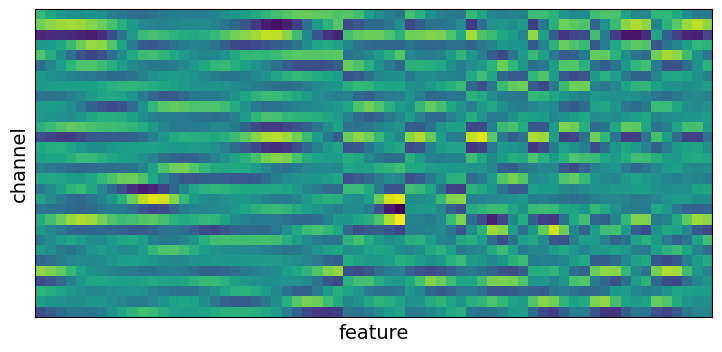

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(25, 4))
ax.imshow(full_delay_phase_results['pattern'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_channel_pattern.png')
plt.savefig(plot_path, bbox_inches='tight')

In [27]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

channel_weight_projection = delay_model.raw_ys_to_channel_weights(
    np.arange(180), delay_sharpness)
full_patterns = channel_weight_projection @ full_delay_phase_results['pattern'] 
pattern_mask = np.arange(9) * 20 + 10

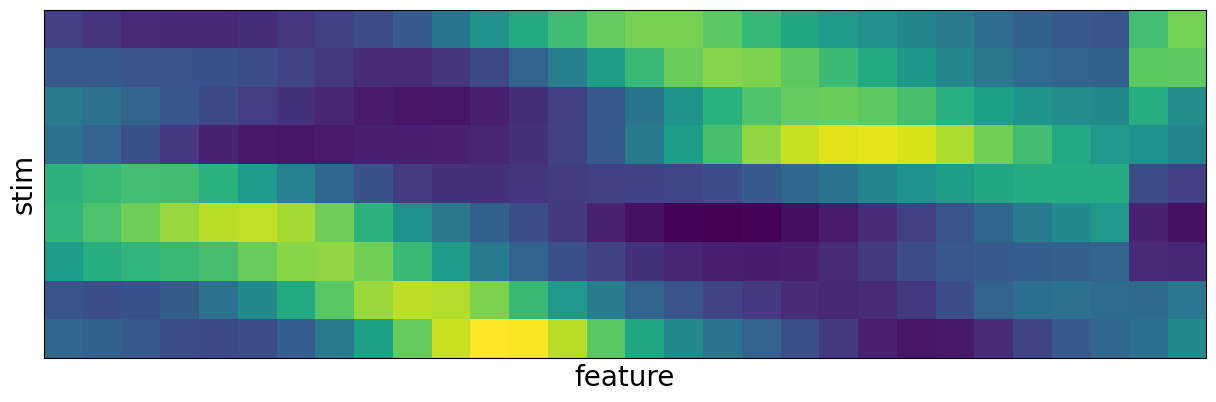

In [28]:
# display 1d patterns
fig, ax = plt.subplots(1, figsize=(15, 10))
selected_pattern = full_patterns[pattern_mask]
f_mask = DEFAULT_FEATURE_CONVERSION['1d']['old']
selected_pattern = selected_pattern[:, f_mask]
ax.imshow(selected_pattern, origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('stim', fontsize=20)
ax.set_xlabel('feature', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_1d.png')
plt.savefig(plot_path, bbox_inches='tight')

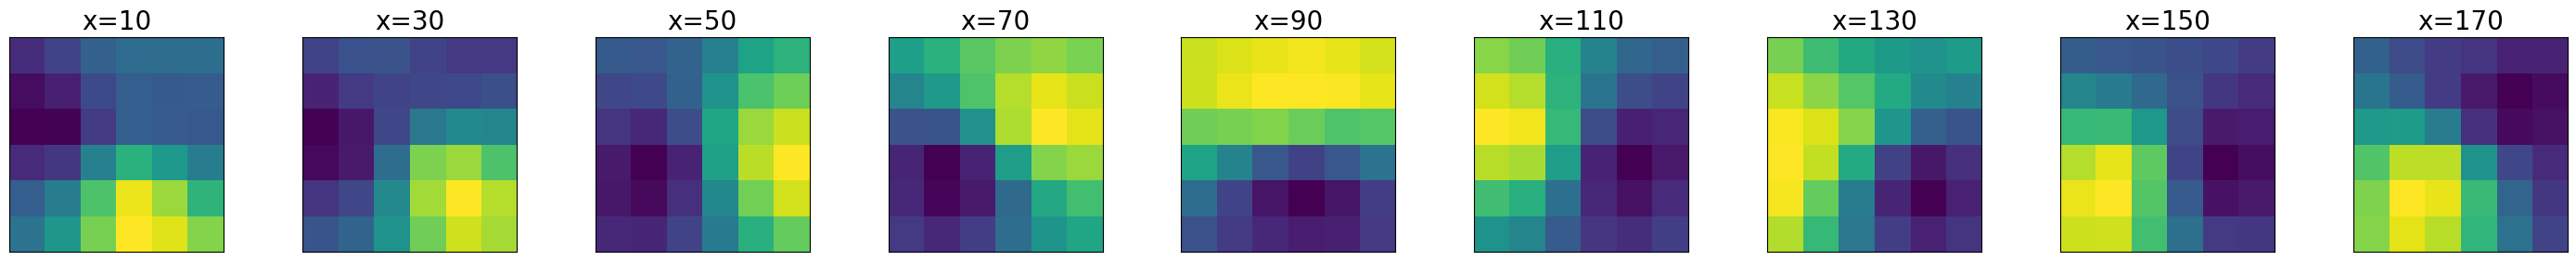

In [29]:
# display 2d patterns
fig, axs = plt.subplots(1, len(pattern_mask), figsize=(4*len(pattern_mask), 3))
selected_pattern = full_patterns[pattern_mask]
f_mask_start = 32 if '0d' in DEFAULT_FEATURE_CONVERSION else 30
selected_pattern = selected_pattern[:, f_mask_start:]

for i in range(len(pattern_mask)):
    ax = axs[i]
    cond_pattern = selected_pattern[i]
    pattern_H = int(
        DEFAULT_FEATURE_CONVERSION['2d']['H'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    pattern_W = int(
        DEFAULT_FEATURE_CONVERSION['2d']['W'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    cond_pattern = cond_pattern.reshape(pattern_H, pattern_W)
    ax.imshow(cond_pattern, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'x={pattern_mask[i]}', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_2d.png')
plt.savefig(plot_path, bbox_inches='tight')

### center all encoded

#### convert channel weights to (distribution of) stimuli

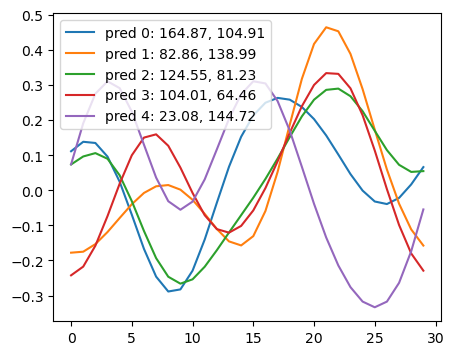

In [30]:
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = full_delay_phase_results['preds'][i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

In [31]:
DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])
print(f'Delay channel prediction mean: {DELAY_CHANNEL_PRED_MEAN:.2f} std: {DELAY_CHANNEL_PRED_STD:.2f}')

Delay channel prediction mean: 0.03 std: 0.23


In [32]:
def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    default_degs = np.arange(180)
    projection = model.raw_ys_to_channel_weights(
        default_degs, sharpness)
    
    # pos_thresh, neg_thresh = 6, -4
    # channel_weights = np.clip(channel_weights, neg_thresh, pos_thresh)
    
    channel_weights = (channel_weights - DELAY_CHANNEL_PRED_MEAN) / DELAY_CHANNEL_PRED_STD
    channel_weights = np.clip(channel_weights, -4, 4)
    
    channel_weights = channel_weights - np.min(channel_weights, axis=-1, keepdims=True) + 1e-5
    pdistrib = channel_weights @ projection.T

    # baseline_vec = projection / np.linalg.norm(projection, axis=-1, keepdims=True)
    # dist_to_baseline = DistFunctions.cos_diff(channel_weights, baseline_vec, pairwise=True)
    # sim_to_baseline = 2 - dist_to_baseline # scale to 0-2
    # pdistrib = sim_to_baseline / np.sum(sim_to_baseline, axis=-1, keepdims=True)

    # now make them a distribution
    distrib = pdistrib / np.sum(pdistrib, axis=-1, keepdims=True)

    return distrib
    

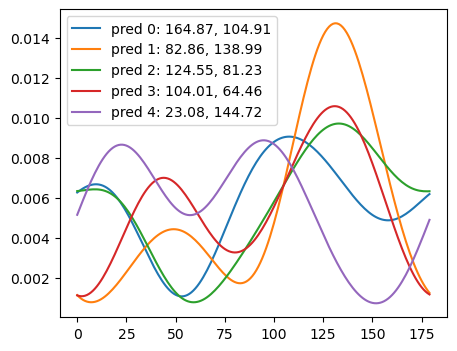

In [33]:
example_converted = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=30)
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = example_converted[i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

#### flip and adjust the distribution --> so it aligns with the target we are checking

In [34]:
def shift_align_distrib(distrib, targets, refs=None):
    # filter out nan
    valid_mask = ~(np.isnan(targets))
    default_results = np.zeros_like(distrib)
    if refs is not None:
        valid_mask = valid_mask & ~(np.isnan(refs))
    distrib = distrib[valid_mask]
    targets = targets[valid_mask]
    if refs is not None:
        refs = refs[valid_mask]
    default_results[~valid_mask] = np.nan

    targets = targets.astype(int) % 180

    # determine the new x for each distrib
    default_degs = np.arange(180)
    default_diffs = deg_signed_diff(
        np.subtract.outer(targets, default_degs))
    relative_xs = - default_diffs
    if refs is not None:
        sd_diffs = deg_signed_diff(refs-targets)
        flip_mask = sd_diffs < 0
        relative_xs[flip_mask] = - relative_xs[flip_mask]
    relative_xs = (np.round(relative_xs) % 180).astype(int)
    # shift it: error = 0, 1,... 89, 90, -89,...-1
    shifted = np.zeros_like(distrib)
    row_indices = np.arange(len(distrib))[:, np.newaxis]
    col_indices = np.arange(180)
    shifted[row_indices, relative_xs] = distrib[
        row_indices, col_indices]
    default_results[valid_mask] = shifted

    return default_results, valid_mask

In [35]:
def display_shifted_distrib(ax, distrib, mask=None, label=None, min_max_y=1.2e-2, ref_type=None):
    # filter out those too vague (likely large error)
    # print(f'kept: {np.mean(distrib.max(axis=-1) > min_max_y):.2f}')
    # distrib = distrib[distrib.max(axis=-1) > min_max_y]
    if mask is not None:
        distrib = distrib[mask]
    
    # sort from -180 to 180 (0 for target)
    summed = np.mean(distrib, axis=0)
    summed_xs = deg_signed_diff(np.arange(180))
    summed_idx = np.argsort(summed_xs)
    summed = summed[summed_idx]
    summed_xs = summed_xs[summed_idx]

    ax.plot(summed_xs, summed, label=label)
    ax.axvline(0, color='red', linestyle='--')
    if ref_type == 'previous':
        ax.set_xticks([-45, 45])
        ax.set_xticklabels([
            '<<away from previous resp<<', 
            '>>towards previous resp>>'], fontsize=14)
        ax.set_xlabel('error (corrected)', fontsize=14)
    elif ref_type == 'nontarget':
        ax.set_xticks([-45, 45])
        ax.set_xticklabels([
            '<<away from non-target<<', 
            '>>towards non-target>>'], fontsize=14)
        ax.set_xlabel('error (corrected)', fontsize=14)
    elif ref_type == 'target':
        ax.set_xlabel('error', fontsize=14)
    else:
        raise  NotImplementedError(f'Unknown ref_type {ref_type}')
    ax.set_ylabel('probability', fontsize=14)
    ax.axhline(1/180, color='red', linestyle='--')
    ax.set_ylim([0.0045, 0.0065])

#### Quantify the bias (using Fischer2024 method)

In [36]:
def compute_accuracy(distrib, T=180):
    # 0 --> err = 0
    # 0.5 --> max err
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.cos(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)
    acc = np.sum(distrib_vec * baseline_vec, axis=-1)
    return acc

def compute_bias(distrib, T=180, err_thresh=40):
    # 0 --> no bias
    # 0.25 --> most positive bias
    # 0.5 --> neutral?
    # 0.75 --> most negative bias
    degs = np.linspace(0, 360, T, endpoint=False)
    errs = deg_signed_diff(degs, epoch=360)
    baseline_vec = np.sin(np.deg2rad(errs))

    # baseline_vec = baseline_vec / np.linalg.norm(baseline_vec)
    # distrib_vec = distrib
    distrib_vec = distrib / np.linalg.norm(distrib, axis=-1, keepdims=True)

    # error filtering
    total_weights = np.linalg.norm(baseline_vec)
    if err_thresh is None:
        err_thresh = 180
    mask = np.abs(errs) <= (err_thresh * 360 / T)
    distrib_vec = distrib_vec[mask]
    baseline_vec = baseline_vec[mask]
    kept_weights = np.linalg.norm(baseline_vec)

    ratio = total_weights / kept_weights
    bias = np.sum(distrib_vec * baseline_vec, axis=-1) * ratio
    return bias

In [37]:
stat_func_mapping = {
    'accuracy': compute_accuracy,
    'bias': compute_bias,
}

def subjlevel_bias_stats(pred_distrib, df, cond_lmb, stat_type):
    if cond_lmb is not None:
        valid_mask = cond_lmb(df)
        pred_distrib = pred_distrib[valid_mask]
        df = df[valid_mask]

    subj_stats = {}
    for subj in all_subjs:
        subj_mask = df['participant'] == int(subj)
        subj_bias = np.nan
        if np.sum(subj_mask) > 0:
            subj_distrib = pred_distrib[subj_mask]
            subj_distrib = np.mean(subj_distrib, axis=0)
            subj_bias = stat_func_mapping[stat_type](subj_distrib)
        subj_stats[subj] = subj_bias
    return subj_stats

#### Combine visualization

In [38]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

In [39]:
def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False # if to return each subject's stats
    ):
    y_pred_distrib = channel_weights_to_pseudo_distrib(
        results['preds'], delay_model, sharpness=sharpness)
    y_df = results['test_df']
    ys = results['test_ys']
    if common_lmb is not None:
        # common lmb to select a subset to analyze
        valid_mask = common_lmb(y_df)
        y_df = y_df[valid_mask]
        y_pred_distrib = y_pred_distrib[valid_mask]
        ys = ys[valid_mask]

    # combined should combined with masking
    if item_weights_lmb is None:
        raise ValueError('item_weights_lmb should be specified')
    item_weights = item_weights_lmb(y_df)

    # compute distribs
    y_distribs_results = {}
    for sid, stim_name in enumerate(['stim 1', 'stim 2']):
        # specify the references to compare with
        refs = None
        if stats_type == 'accuracy':
            pass
        elif stats_type == 'sd':
            refs = y_df['prev_last_response'].to_numpy(copy=True)
        elif stats_type == 'sur':
            ref_code = 2 - sid
            refs = y_df[f'stim_{ref_code}'].to_numpy(copy=True)
        else:
            raise NotImplementedError(f'Unknown stats type {stats_type}')

        y_distrib, _ = shift_align_distrib(
            y_pred_distrib, ys[:, sid], refs=refs)
        # remove the irrelevant item bias
        n_irr_id = 1 - sid
        n_has_irr = item_weights[:, n_irr_id] > 0
        irr_w = 1 + n_has_irr
        irr_bias = n_has_irr / 180
        y_distrib = y_distrib * irr_w[:, None] - irr_bias[:, None]
        # update
        y_distribs_results[stim_name] = y_distrib

    # further masking if it applies...
    if 'stim 1' in condition_lmbs:
        lmb = condition_lmbs['stim 1']['lmb']
        if lmb is not None:
            stim1_mask = lmb(y_df)
            item_weights[~stim1_mask, 0] = 0
    if 'stim 2' in condition_lmbs:
        lmb = condition_lmbs['stim 2']['lmb']
        if lmb is not None:
            stim2_mask = lmb(y_df)
            item_weights[~stim2_mask, 1] = 0

    item_weights = item_weights.T
    combined_valid_mask = np.sum(item_weights, axis=0) > 0 # at least one of two stims are included
    y_df = y_df[combined_valid_mask]
    y_distribs_results['stim 1'] = y_distribs_results['stim 1'][combined_valid_mask]
    y_distribs_results['stim 2'] = y_distribs_results['stim 2'][combined_valid_mask]
    
    item_weights = item_weights[:, combined_valid_mask]
    item_weights = item_weights / np.sum(item_weights, axis=0, keepdims=True)

    y_combined_distrib = np.array([
        y_distribs_results['stim 1'], 
        y_distribs_results['stim 2']])
    y_combined_distrib = np.sum(
        y_combined_distrib * item_weights[..., None], axis=0)
    y_distribs_results['combined'] = y_combined_distrib
    
    all_stats_vals = {}
    all_subj_stats_vals = {}
    for condname, cond_settings in condition_lmbs.items():
        cond_target = cond_settings['target']
        cond_lmb = cond_settings['lmb']
        cond_mask = None
        if cond_lmb is not None:
            cond_mask = cond_lmb(y_df)
        cond_distrib = y_distribs_results[cond_target]

        # compute stats
        stats_strs = []
        stats_vals = {}
        subj_stats_vals = {}
        # compute accuracy
        all_stats_names = []
        if stats_type == 'accuracy':
            all_stats_names = ['accuracy', 'bias']
        elif stats_type == 'sd':
            all_stats_names = ['bias']
        elif stats_type == 'sur':
            all_stats_names = ['bias']
        else:
            raise NotImplementedError(f'Unknown stats type {stats_type}')

        for stat_name in all_stats_names:
            # get each subject stats
            stats = subjlevel_bias_stats(
                cond_distrib, y_df, cond_lmb, stat_name)
            subj_stats_vals[stat_name] = stats

            # compute mean and sem
            stats = np.array(list(stats.values()))
            stats = stats[~np.isnan(stats)]
            subj_mean = np.mean(stats)
            subj_sem = np.std(stats) / np.sqrt(len(stats))
            stats_strs.append(f'{stat_name}: {subj_mean:.3f}\u00B1{subj_sem:.3f}')
            stats_vals[stat_name] = {
                'mean': subj_mean,
                'sem': subj_sem,
            }
        stats_str = ', '.join(stats_strs)

        # plot the distribution
        if ax is not None:
            ref_type = {
                'accuracy': 'target',
                'sd': 'previous',
                'sur': 'nontarget',
            }[stats_type]
            display_shifted_distrib(ax, cond_distrib, 
                mask=cond_mask, label=f'{condname}:: {stats_str}', 
                ref_type=ref_type)
        
        # update stats
        all_subj_stats_vals[condname] = subj_stats_vals
        all_stats_vals[condname] = stats_vals

    if ax is not None:
        ax.legend(
            fontsize=14, loc="lower center", bbox_to_anchor=(0.5, 0.05))

    final_stats_results = (all_stats_vals, all_subj_stats_vals) if return_subj_stats else all_stats_vals
    return final_stats_results



### Firstly, check the combined

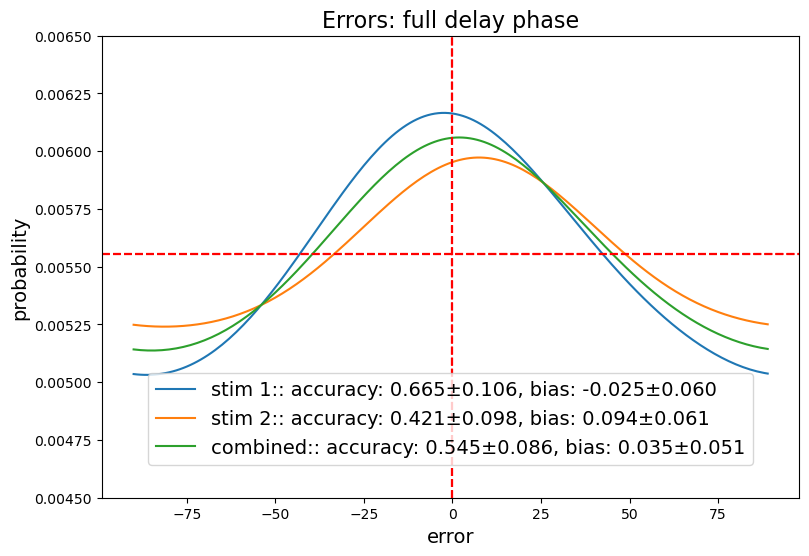

In [40]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


In [41]:
both_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_both_lmb(df))

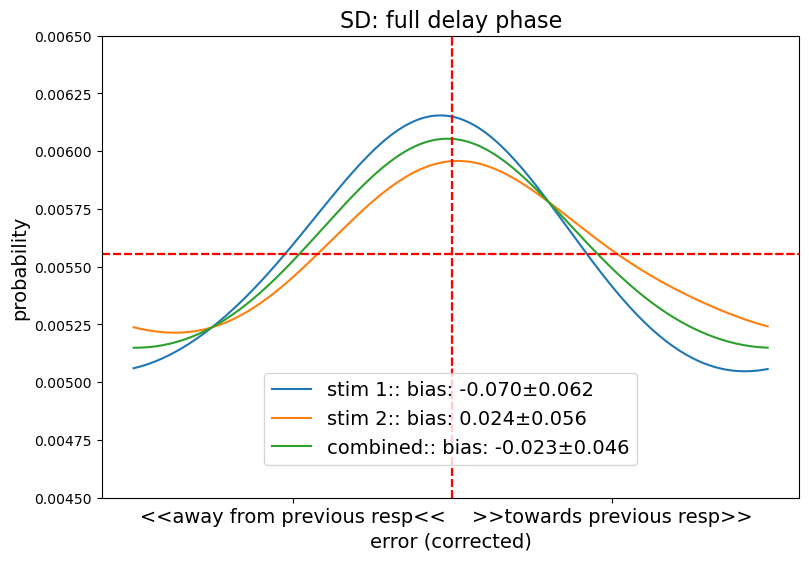

In [42]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('SD: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')


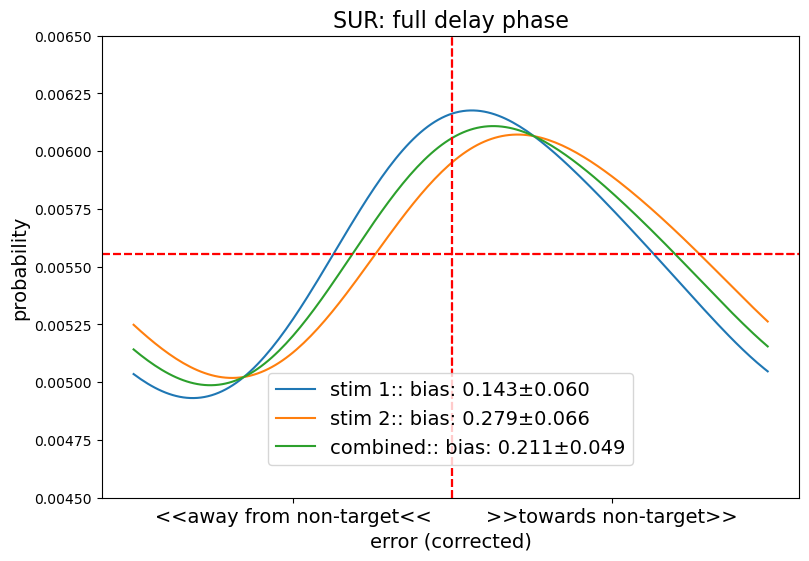

In [43]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=valid_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('SUR: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### for comparison: check one item only decoding-encoding

In [44]:
stim1_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_2_to_report']))).to_numpy()
stim2_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_1_to_report']))).to_numpy()
valid_single_item_lmb = lambda df: (stim1_only_lmb(df) | stim2_only_lmb(df))

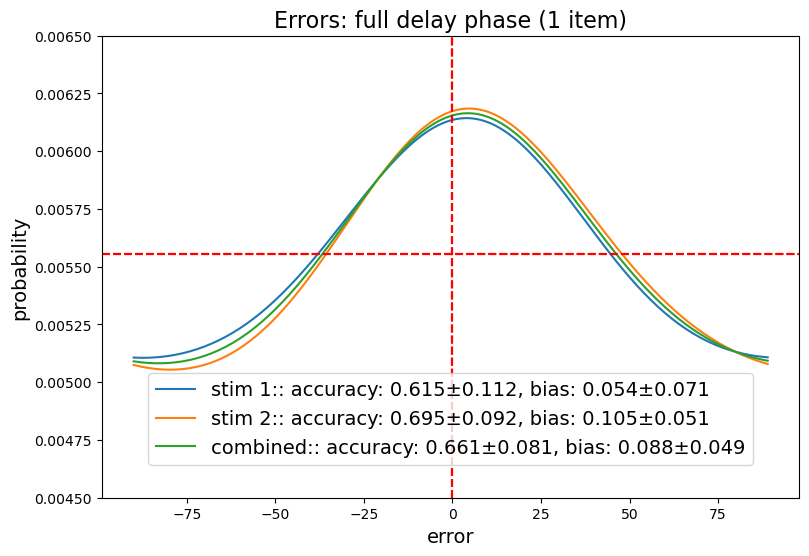

In [45]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('Errors: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [46]:
single_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_single_item_lmb(df))

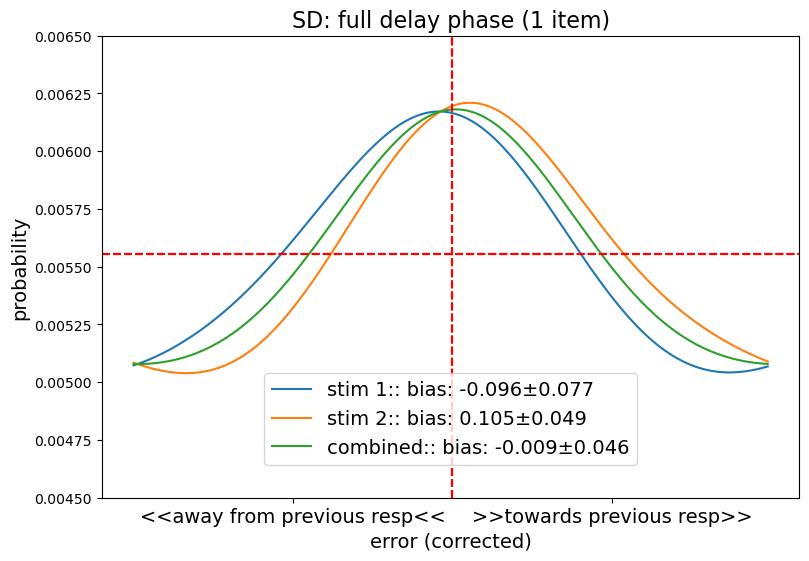

In [47]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=single_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('SD: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

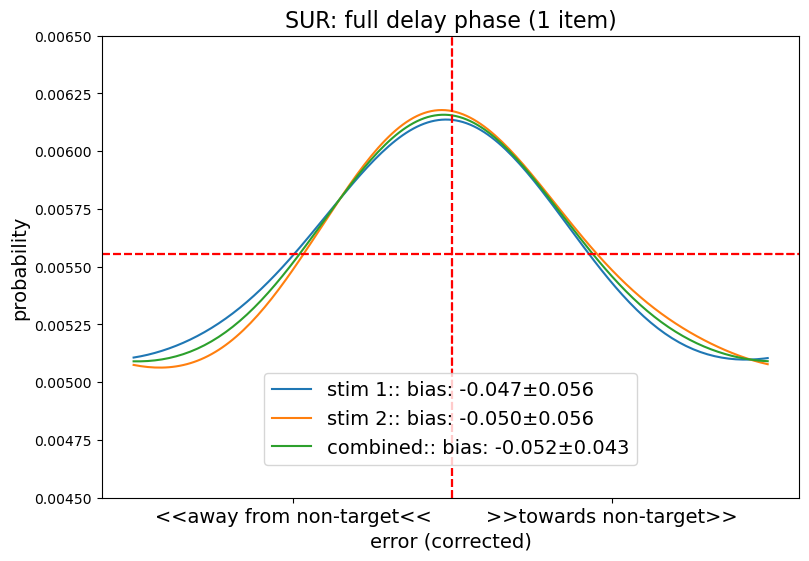

In [48]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('SUR: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### group by serial difference

In [49]:
serial_diffs_s1_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_1'].values))
serial_diffs_s2_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_2'].values)) 

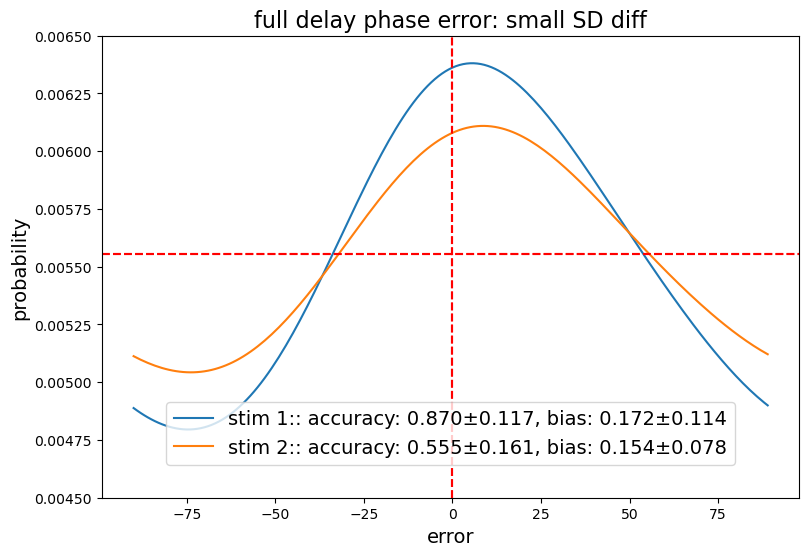

In [50]:
small_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) < 30)
small_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) < 30)

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase error: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

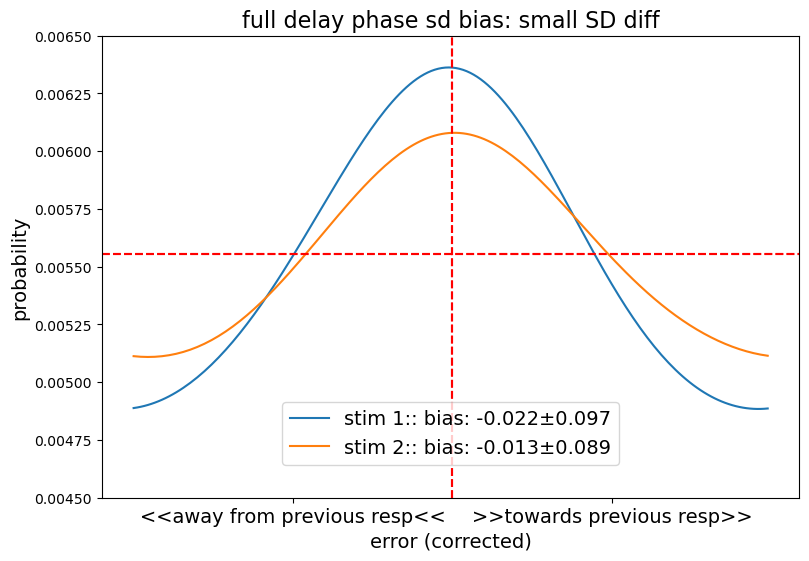

In [51]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase sd bias: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

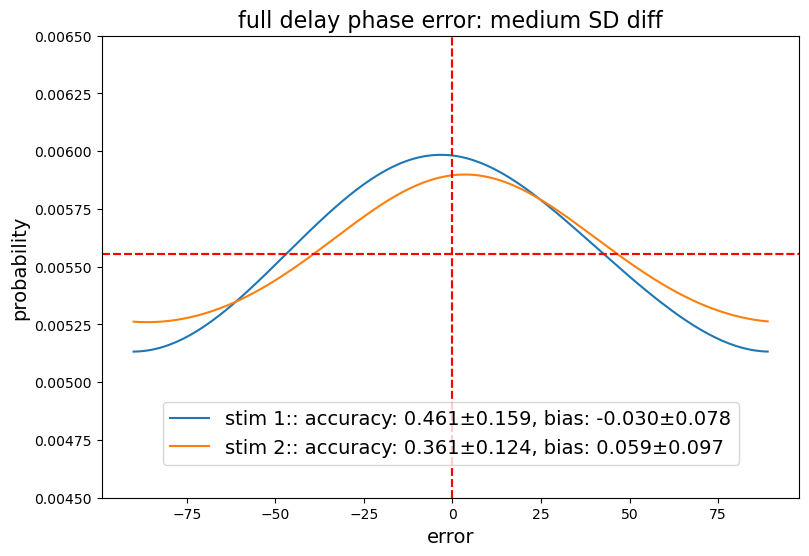

In [52]:
mid_sd1_lmb = lambda d: ((serial_diffs_s1_lmb(d) >= 30) & (serial_diffs_s1_lmb(d) < 60))
mid_sd2_lmb = lambda d: ((serial_diffs_s2_lmb(d) >= 30) & (serial_diffs_s2_lmb(d) < 60))

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase error: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

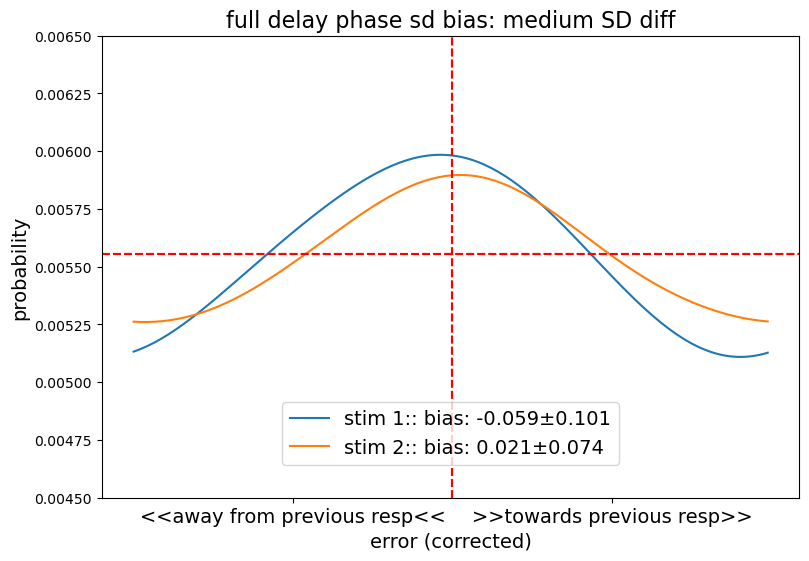

In [53]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase sd bias: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

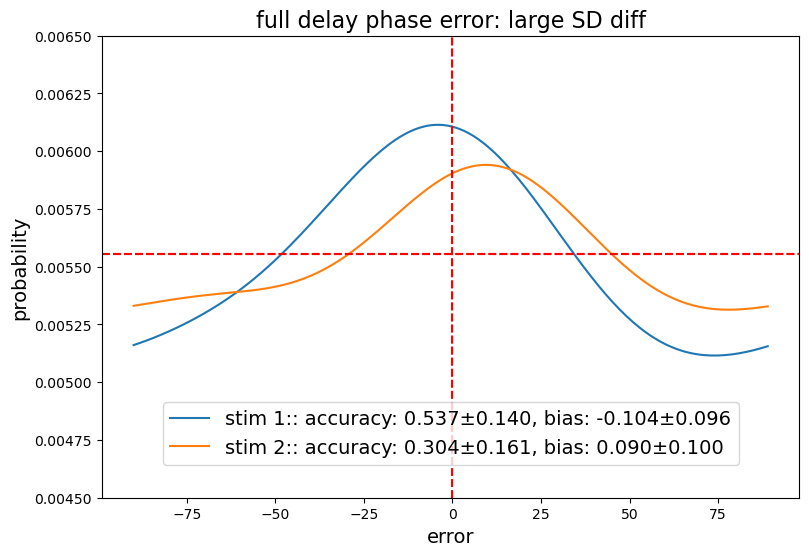

In [54]:
large_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) >= 60)
large_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) >= 60)

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase error: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

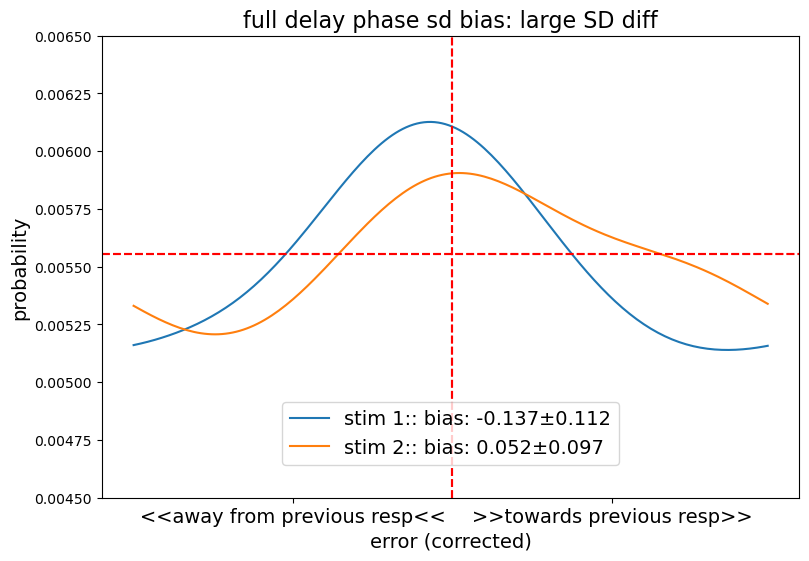

In [55]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase sd bias: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Compare different modes?

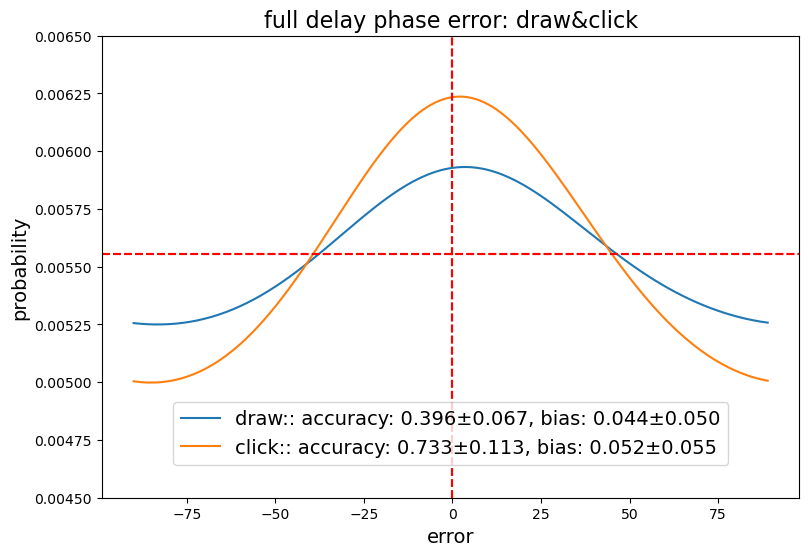

In [56]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase error: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

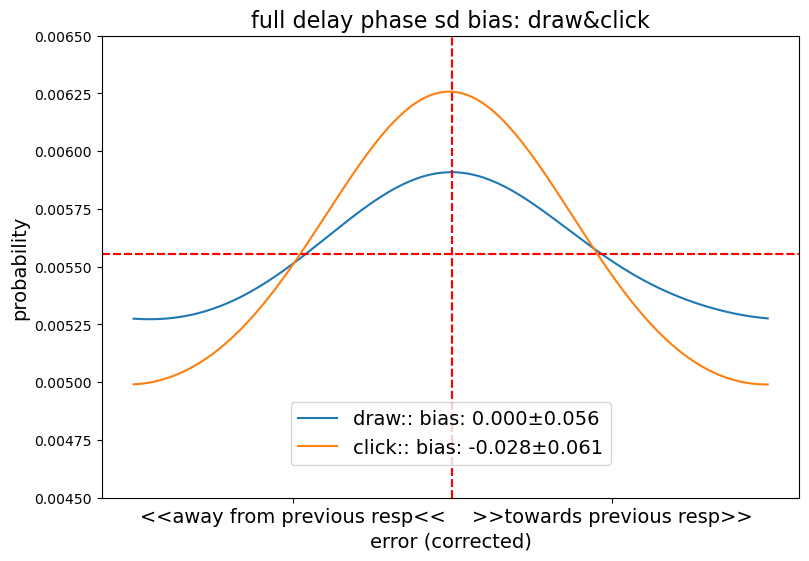

In [57]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase sd bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

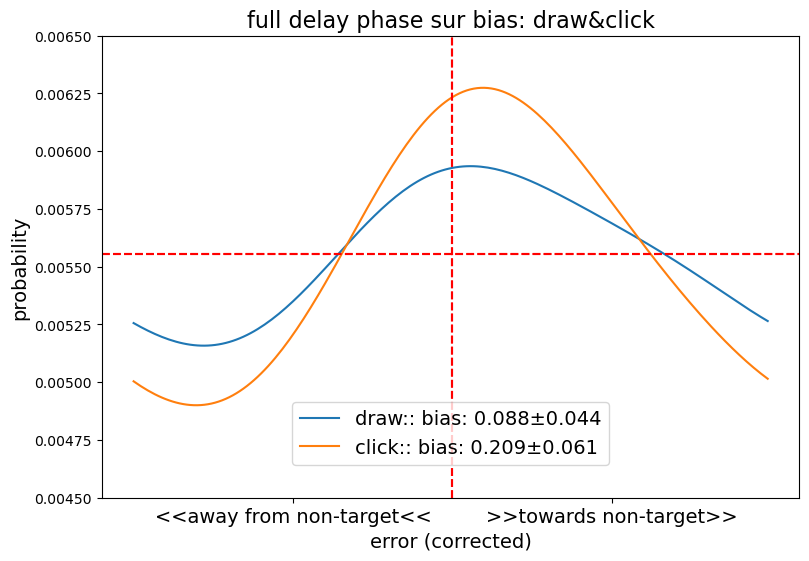

In [58]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}
display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
ax.set_title('full delay phase sur bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

##### Comments:
- Decoding accuracy is impacted by both (1) sequential order of presentation and (2) the feature distance between current and previous item. This speaks to RSA results, serves as another indirect evidence that perceptual history serves to 'stabilize' the system
- But why we do not see significant bias overall? Here we have concatenated data across the whole 5 seconds delay; following analysis will show the direction of bias change over time...

### Train & test across modes

In [59]:
draw_delay_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_delay_lmb = lambda df: (df['mode'] == 'click').to_numpy()
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [60]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: convert_df_to_design_matrix(df)
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw


Processing: 100%|██████████| 33/33 [00:07<00:00,  4.69it/s]


Trained on draw, tested on click


Processing: 100%|██████████| 33/33 [00:06<00:00,  5.45it/s]


Trained on click, tested on draw


Processing: 100%|██████████| 33/33 [00:06<00:00,  5.48it/s]


Trained on click, tested on click


Processing: 100%|██████████| 33/33 [00:06<00:00,  5.04it/s]


In [61]:
mode_prev_lmbs = {
    'draw': lambda df: draw_lmb(df) & has_valid_prev_lmb(df),
    'click': lambda df: click_lmb(df) & has_valid_prev_lmb(df),
}

#### For simplicity: combining N=1 and N=2

draw -> draw
draw -> click
click -> draw
click -> click


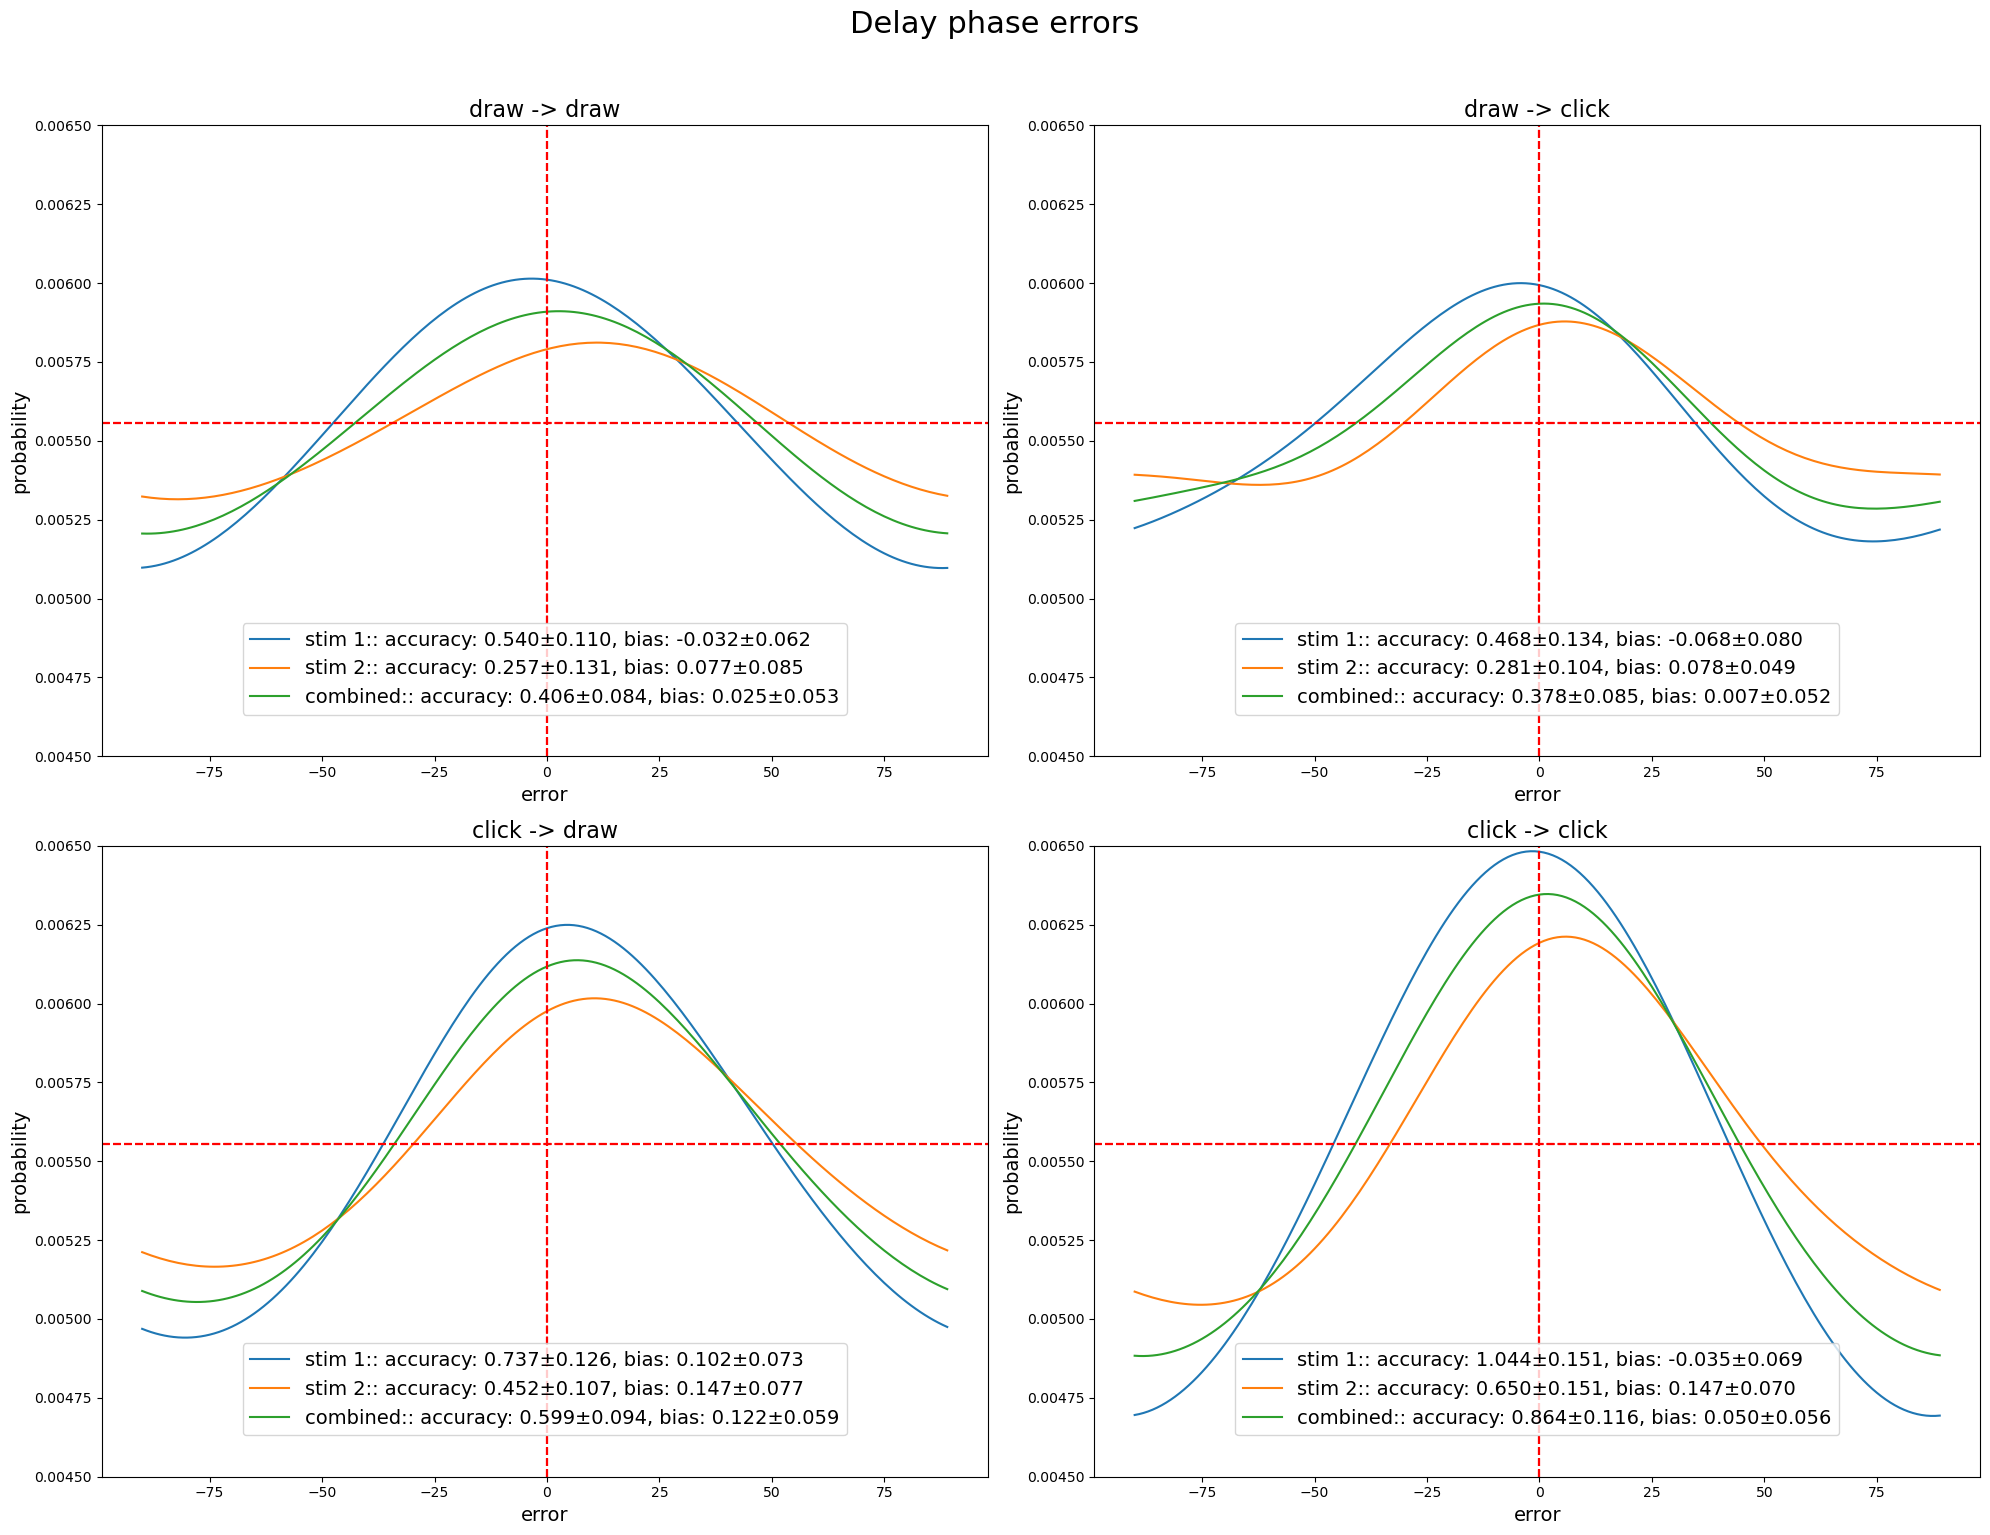

In [62]:
stim1_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
stim2_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_2_to_report'])).to_numpy()

plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_lmbs[test_mode]
        display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        ax.set_title(f'{train_mode} -> {test_mode}', fontsize=16)

plt.suptitle('Delay phase errors', fontsize=22, y=1.02)
plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

draw -> draw
draw -> click
click -> draw
click -> click


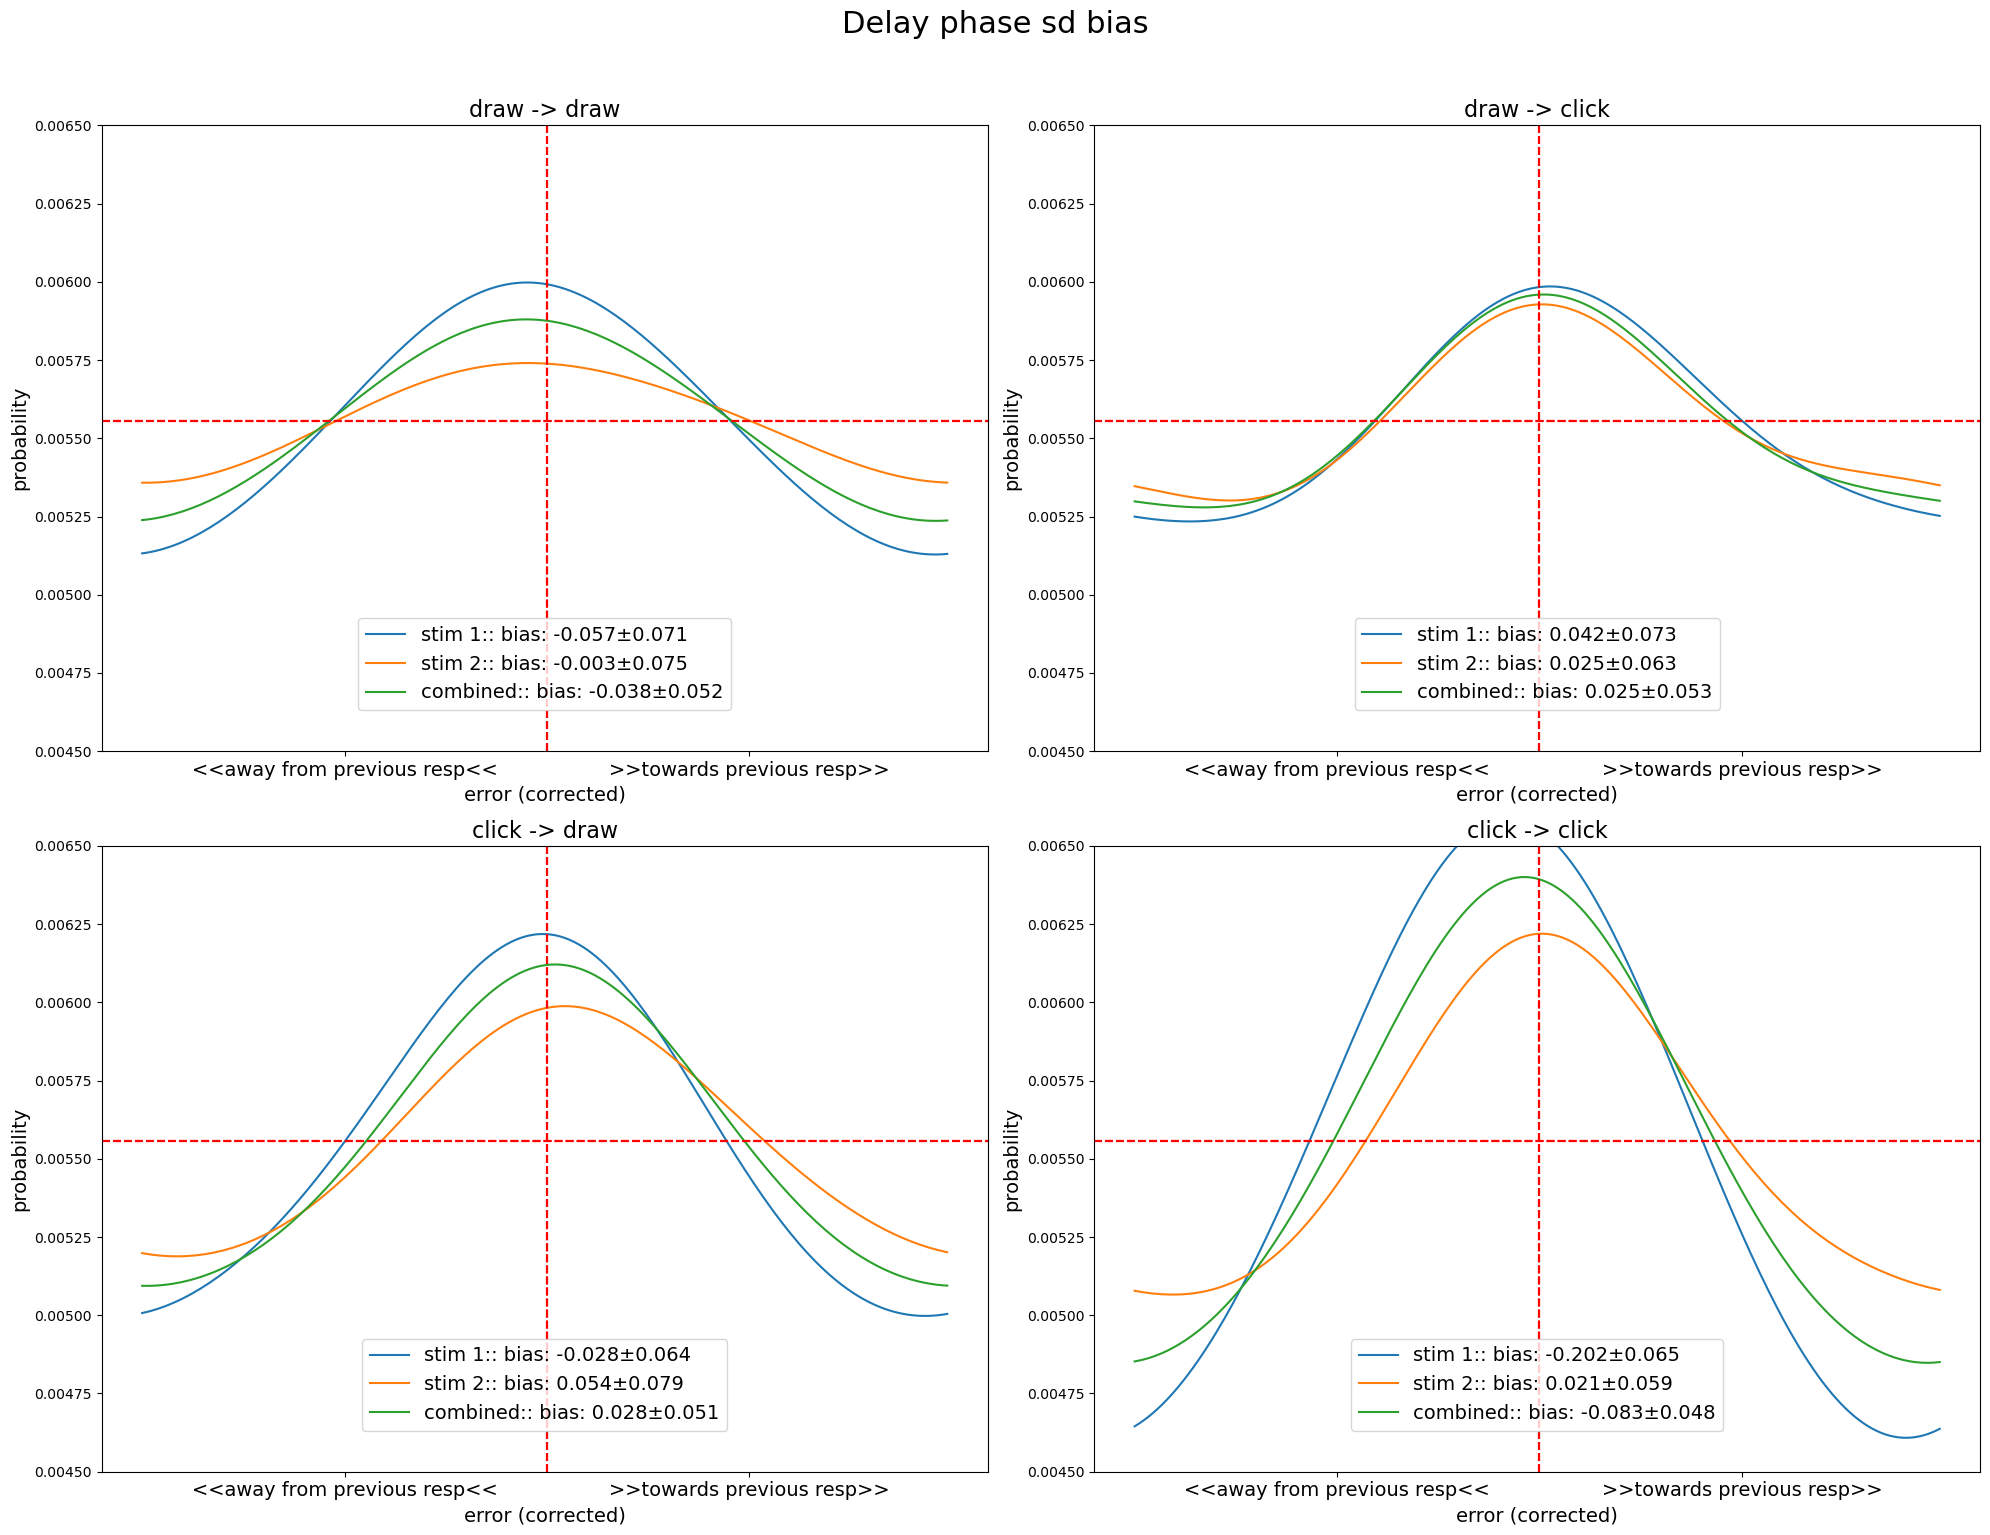

In [63]:
# also check serial bias
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        ax = axs[i, j]
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_prev_lmbs[test_mode]
        display_stats_and_distrib(ax,
            results,
            stats_type='sd', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        ax.set_title(f'{train_mode} -> {test_mode}', fontsize=16)

plt.suptitle('Delay phase sd bias', fontsize=22, y=1.02)
plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Store subject accuracy

In [64]:
def store_subject_stats(results, common_lmb, condition_lmbs, stats_type, cond_name,
        item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness):
    # collect subject level stats
    stats_results = display_stats_and_distrib(
        ax=None,
        results=results, 
        stats_type=stats_type, 
        common_lmb=common_lmb, 
        condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb, 
        sharpness=sharpness,
        return_subj_stats=True # need subject wise stats
    )
    stats_results = stats_results[1] # fetch only subject level stats

    # store it
    sub_result_folder = os.path.join(PROCESSED_FOLDER, f'{cond_name}')
    os.makedirs(sub_result_folder, exist_ok=True)
    result_path = os.path.join(sub_result_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(stats_results, f, indent=4)

##### store subject accuracy during drawing v.s. clicking tasks

In [65]:
for mode in ['draw', 'click']:
    test_lmb = mode_lmbs[mode]
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            all_delay_across_modes[(mode, mode)], 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'whole_delay_{mode}2{mode}',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
    

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### (Exp): can we see cardinal / oblique bias in prediction?

In [66]:
def get_stim_restrict_bias(results, common_lmb, center_sample, window_size,
        item_weights_lmb=item_weights_lmb, to_fetch='combined', sharpness=delay_best_sharpness):
    stim1_within_range_lmb = lambda df: (
        stim1_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_1'].values -center_sample)) <= window_size))
    stim2_within_range_lmb = lambda df: (
        stim2_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_2'].values - center_sample)) <= window_size))
    at_least_one_within_lmb = lambda df: (
        stim1_within_range_lmb(df) | stim2_within_range_lmb(df))

    plot_settings = {
        'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_within_range_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_within_range_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': at_least_one_within_lmb,
        },
    }
        
    stats = display_stats_and_distrib(
        ax=None, results=results, stats_type='accuracy', 
        common_lmb=common_lmb, condition_lmbs=plot_settings, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness)   

    # only fetch the acc and bias from the combined
    stats = stats[to_fetch]
    return stats

In [67]:
def display_acc_bias_as_tuning(results, common_lmb, condition_name,
        item_weights_lmb=item_weights_lmb,
        to_fetch='combined', sharpness=delay_best_sharpness):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        stats = get_stim_restrict_bias(
            results,
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step,
            item_weights_lmb=item_weights_lmb,
            to_fetch=to_fetch,
            sharpness=sharpness
        )
        collected_sample_stats.append(stats)

    # make it wrap around
    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([-1.0, 2.0])
    axs[0].set_yticks(np.arange(-0.5, 2.0, 0.5))
    axs[0].set_ylabel('accuracy', fontsize=14)
    axs[1].set_ylim([-1.5, 1.5])
    axs[1].set_yticks(np.arange(-1.5, 2.0, 0.5))
    axs[1].set_ylabel('bias', fontsize=14)


    # save the figure
    plot_path = os.path.join(PLOTS_FOLDER, f'{condition_name}_delay_decoded_tuning_func.png')
    plt.savefig(plot_path, bbox_inches='tight')



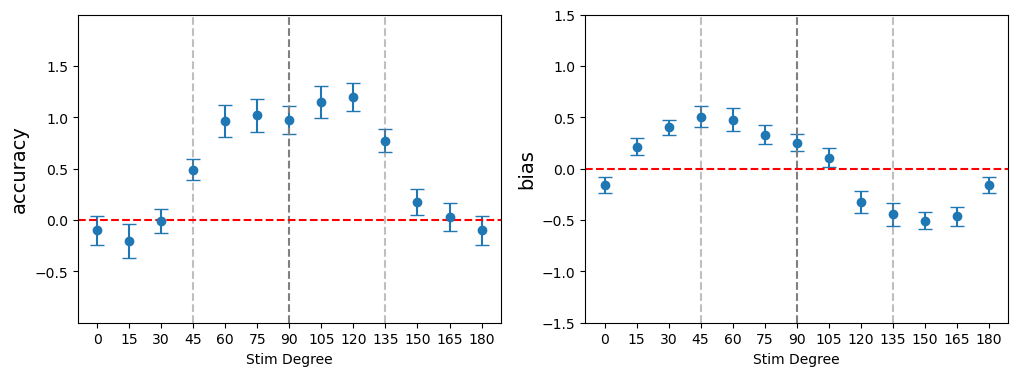

In [68]:
default_lmb = lambda df: np.ones(len(df), dtype=bool)
display_acc_bias_as_tuning(
    results=full_delay_phase_results,
    common_lmb=default_lmb, condition_name='all')

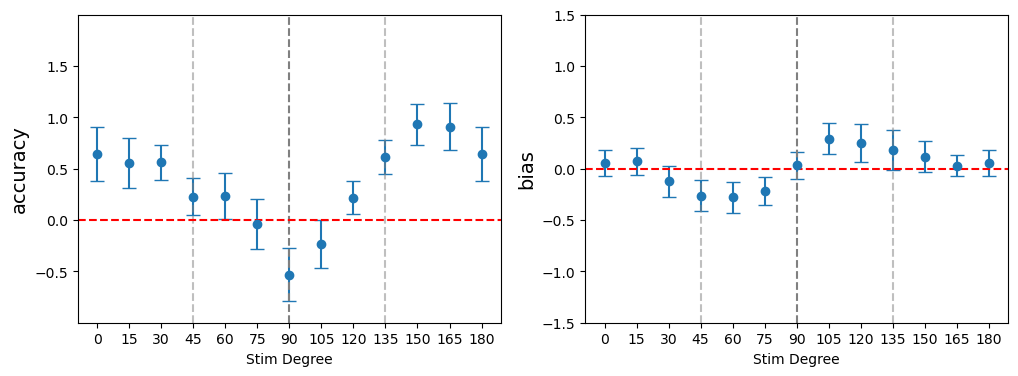

In [69]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('draw', 'draw')],
    common_lmb=draw_lmb, condition_name='draw')

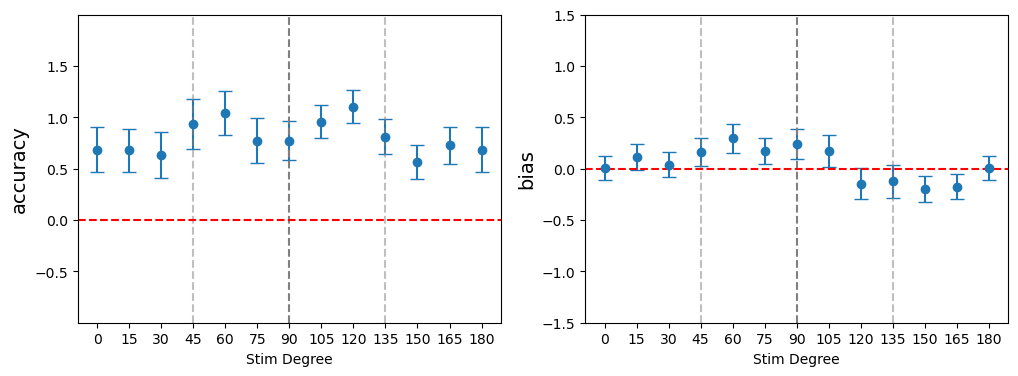

In [70]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('click', 'click')],
    common_lmb=click_lmb, condition_name='click')

##### What about ISI

In [71]:
from copy import deepcopy

DEFAULT_ISI_FORWARD_MODEL_PARAMS = deepcopy(DEFAULT_FORWARD_MODEL_PARAMS)
DEFAULT_ISI_FORWARD_MODEL_PARAMS['forward']['sharpness'] = ISI_best_sharpness


In [72]:
valid_isi_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
isi_item_weights_lmb = lambda df: np.array([
    np.ones(len(df)),
    np.zeros(len(df)),
]).T
isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

Processing: 100%|██████████| 33/33 [00:03<00:00,  9.99it/s]


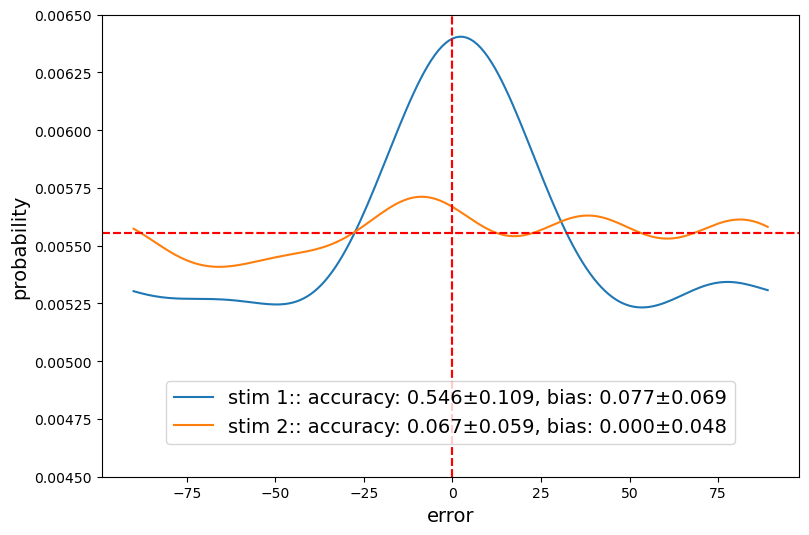

In [73]:
fig, ax = plt.subplots(1, figsize=(9, 6))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

display_stats_and_distrib(ax,
    isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

plot_path = os.path.join(PLOTS_FOLDER, 'isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

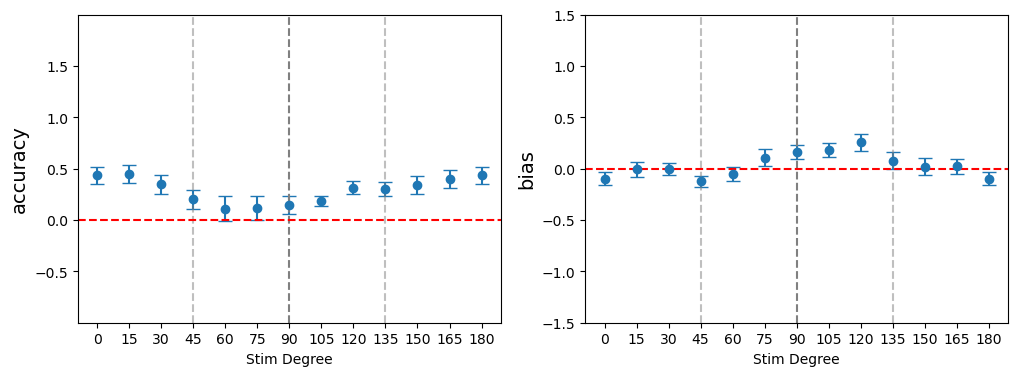

In [74]:
display_acc_bias_as_tuning(
    results=isi_decode_results,
    common_lmb=valid_isi_lmb, condition_name='isi',
    item_weights_lmb=isi_item_weights_lmb,
    to_fetch='stim 1',
    sharpness=ISI_best_sharpness)

##### Also store the combined ISI v.s. Full-delay results

In [75]:
## isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        isi_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [76]:
## delay
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        full_delay_phase_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### Comments
- clicking is easier to decode; drawing seems more complex
- the distribution of erros is not perfectly centered at 0
- No clear traces of serial bias
- The transformation from channel activation prediction to stimuli seems trivial but is actually crucial but I haven't figured out a perfect solution...


## Now further split the delay

#### create sliding windows throughout the delay

In [77]:
def generate_windows(phases, window_size, step_size):
    windows = []
    window_idx = 0
    while window_idx+window_size <= len(phases):
        window = phases[window_idx:window_idx+window_size]
        windows.append(window)
        window_idx += step_size
    return windows

In [78]:
DELAY_WINDOWS = generate_windows(delay_phase, 20, 7)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

11 windows, each of 20 time points


### distribution of errors

In [79]:
def within_across_phase_train_test(phases, train_test_lmb):
    all_phase_steps = [0, 1]
    n_train_phases = len(phases)
    phases_results = [[] for _ in all_phase_steps]

    n_subjects = len(all_subjs)
    for train_id in tqdm(range(n_train_phases)):
        for phase_step in all_phase_steps:
            test_id = train_id + phase_step
            if test_id >= len(phases):
                continue
            # get results
            train_phase = phases[train_id]
            test_phase = phases[test_id]
            results = cv_train_test_invert_encoding(
                DEFAULT_FORWARD_MODEL_PARAMS, 
                train_phase, test_phase, 
                ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
                train_test_lmb, train_test_lmb, 
                item_weights_lmb, n_subjects, use_tqdm=False)
            phases_results[phase_step].append(results)

    return phases_results

In [80]:
def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None):
    collected_stats = []
    
    # compute the stats at each step
    for phase_results in pred_results:
        result_stats = display_stats_and_distrib(
            None, phase_results,
            stats_type=stats_type, 
            common_lmb=common_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        result_stats = result_stats['combined']
        collected_stats.append(result_stats)

    plot_xs = np.arange(len(collected_stats))+1
    xs_names = [f'{train_id}->{train_id + phase_step}' for train_id in plot_xs]
    
    # collect xs, ys, yerrs
    ys = [ss[stat_name]['mean'] for ss in collected_stats]
    yerrs = [ss[stat_name]['sem'] for ss in collected_stats]

    # plot it
    ax.errorbar(plot_xs, ys, yerrs, fmt='o-', label=label)
    ax.set_xticks(plot_xs)
    ax.set_xticklabels(xs_names, rotation=45, fontsize=12)
    
    # set y limits
    pymin, pymax = 0, 0
    if stat_name == 'accuracy':
        pymin = plot_ymin if plot_ymin is not None else 0
        pymax = plot_ymax if plot_ymax is not None else 1.0
    elif stat_name == 'bias':
        pymin = plot_ymin if plot_ymin is not None else -0.2
        pymax = plot_ymax if plot_ymax is not None else 0.2
    ax.set_ylim([pymin, pymax])
    ax.axhline(0, color='gold', linestyle='--')

    ax.set_xlabel('train->test phase', fontsize=14)
    ax.set_ylabel(stat_name, fontsize=14)

def plot_stats_over_phase(pred_results, stats_type, plot_settings, common_lmb, plot_ymin=None, plot_ymax=None):
    stats_names = ['accuracy', 'bias'] if stats_type == 'accuracy' else ['bias']
    nc = len(pred_results)
    nr = len(stats_names)
    fig, axs = plt.subplots(nr, nc, figsize=(4*nc, 3*nr))
    if nc == 1 & nr == 1:
        axs = np.array([[axs]])
    elif nc == 1:
        axs = axs[:, np.newaxis]
    elif nr == 1:
        axs = axs[np.newaxis, :]

    for phase_step_id, collected_phase_results in enumerate(pred_results):
        for j, stat_name in enumerate(stats_names):
            ax = axs[j, phase_step_id]
            plot_single_stats_over_phase(
                ax, collected_phase_results, stats_type, stat_name, phase_step_id,
                plot_settings, common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax)
            ax_title = 'within same phase' if phase_step_id == 0 else f'across +{phase_step_id} phases'
            ax.set_title(ax_title, fontsize=16)

    plt.tight_layout()


#### First check when memory load = 2

In [81]:
mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_both_lmb)

100%|██████████| 11/11 [01:07<00:00,  6.16s/it]


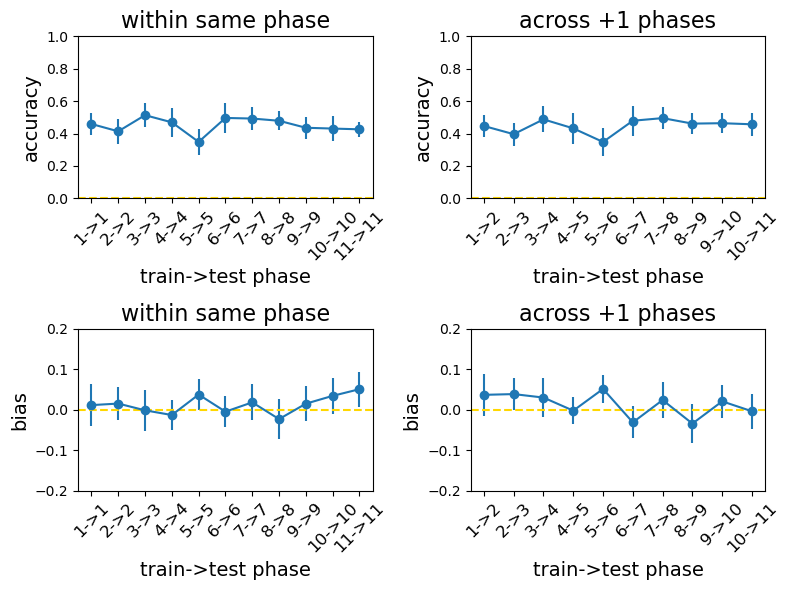

In [82]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'accuracy', 
    plot_settings, valid_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

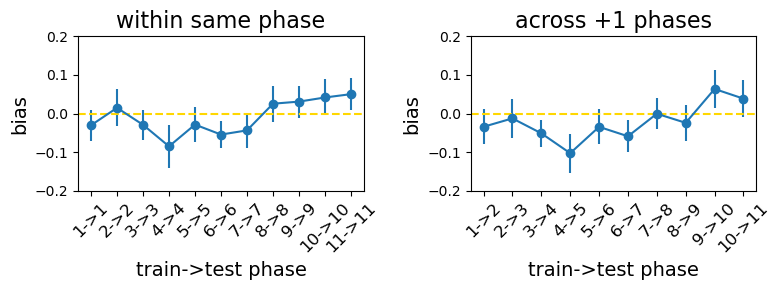

In [83]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'sd', 
    plot_settings, both_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_multi_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

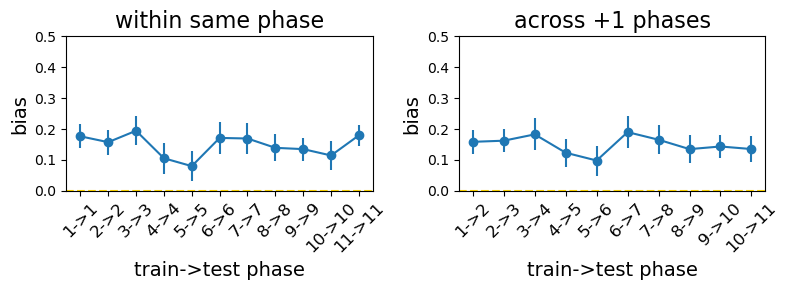

In [84]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'sur', 
    plot_settings, valid_both_lmb,
    plot_ymin=0, plot_ymax=0.5)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_multi_phases_sur_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

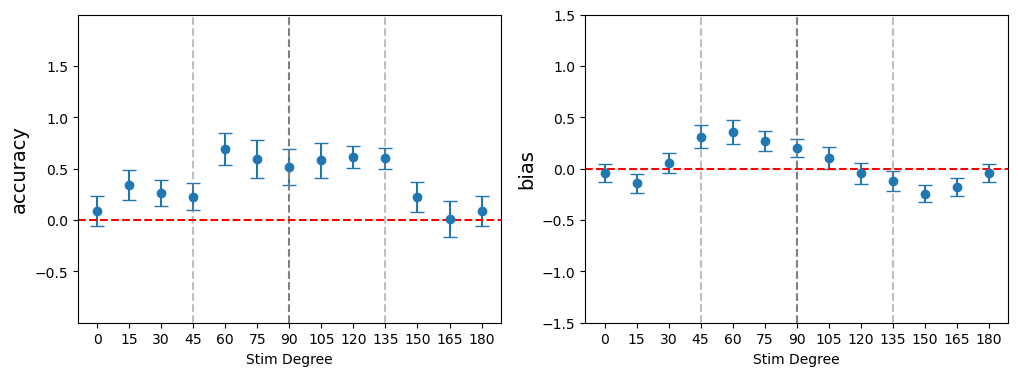

In [85]:
display_acc_bias_as_tuning(
    results=mem2_cross_phase_results[0][-1],
    common_lmb=valid_both_lmb, condition_name='last_phase')

##### Comment:

Probably it is **NOT** possible to tease out surrounding bias...Anyway the decoding of the current target will be interfered by the non-target; but we can check how the bias change over time?

#### Further split the draw and click

##### Drawing

In [86]:
draw_both_lmb = lambda df: ((df['mode'] == 'draw').to_numpy() & valid_both_lmb(df))

In [87]:
draw_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, draw_both_lmb)

100%|██████████| 11/11 [00:49<00:00,  4.48s/it]


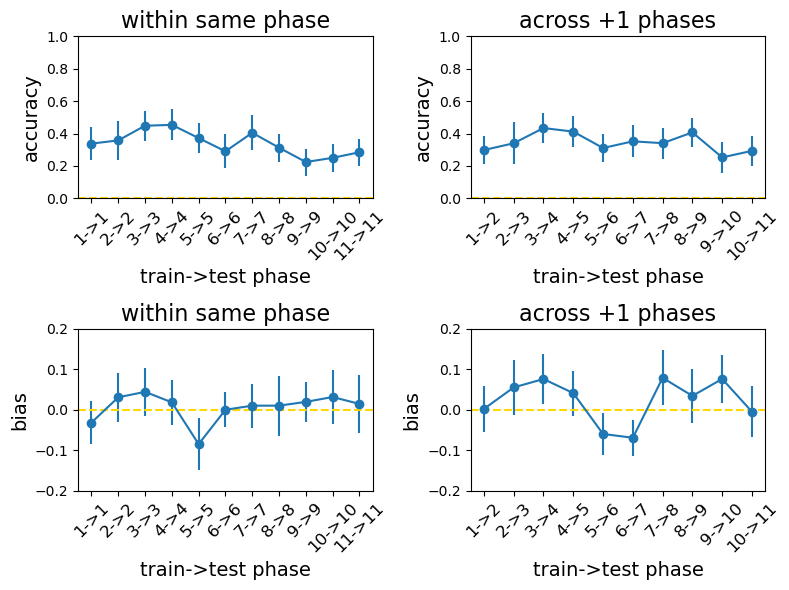

In [88]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    draw_mem2_cross_phase_results, 'accuracy', 
    plot_settings, draw_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'draw_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

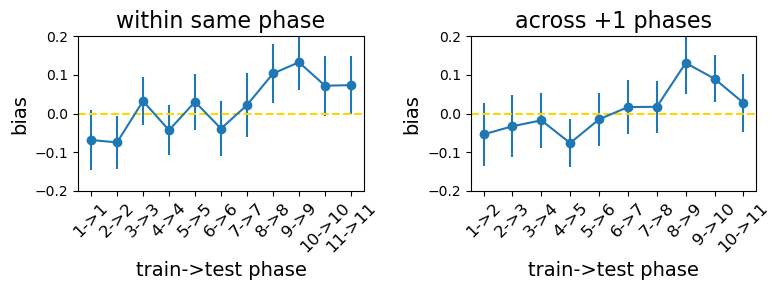

In [89]:
draw_valid_both_prev_lmb = lambda df: (
    (df['mode'] == 'draw').to_numpy() & both_has_prev_lmb(df))

plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    draw_mem2_cross_phase_results, 'sd', 
    plot_settings, draw_valid_both_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'draw_delay_decoded_multi_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

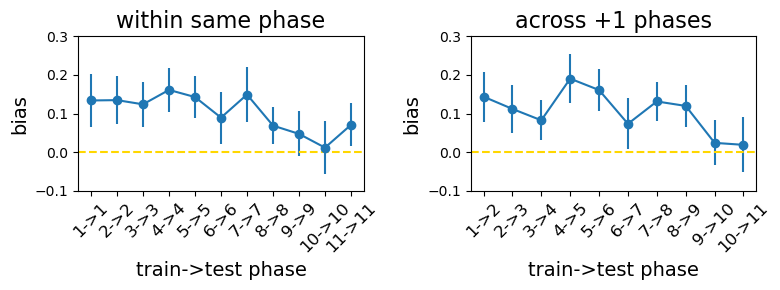

In [90]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    draw_mem2_cross_phase_results, 'sur', 
    plot_settings, draw_both_lmb,
    plot_ymin=-0.1, plot_ymax=0.3)
plot_path = os.path.join(PLOTS_FOLDER, 'draw_delay_decoded_multi_phases_sur_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

##### are there oblique or cardinal bias the last phase ?

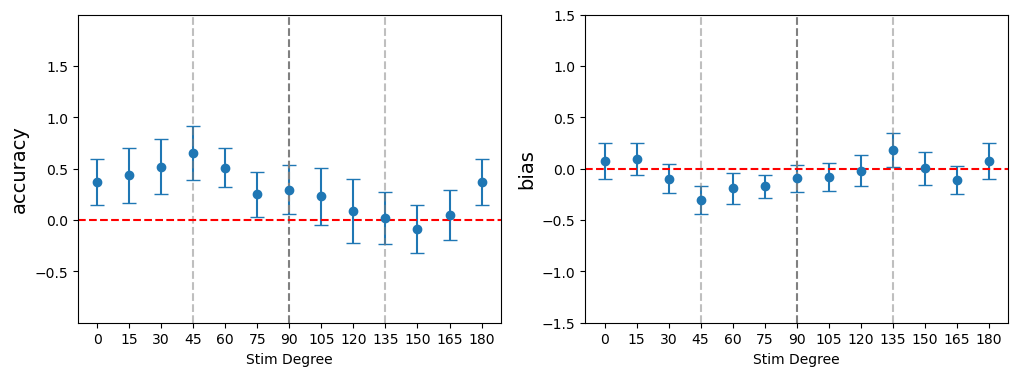

In [91]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][0],
    common_lmb=draw_both_lmb, condition_name='draw_first_phase')

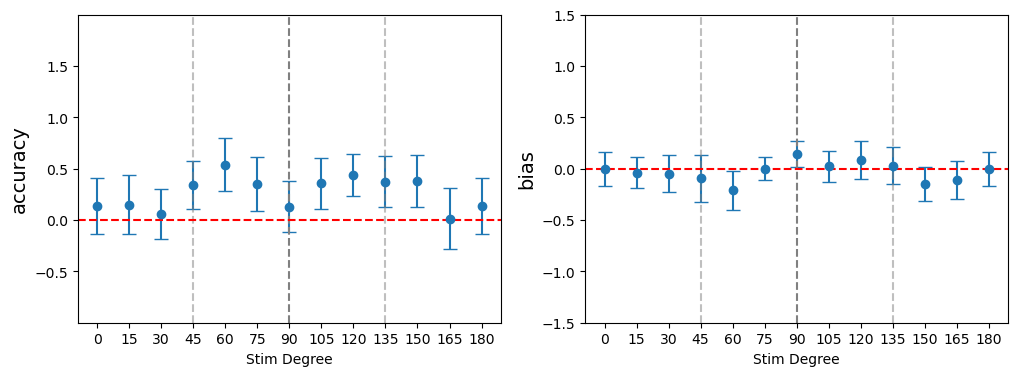

In [92]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][-1],
    common_lmb=draw_both_lmb, condition_name='draw_last_phase')

##### Clicking

In [93]:
click_both_lmb = lambda df: (
    (df['mode'] == 'click').to_numpy() & valid_both_lmb(df))

In [94]:
click_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, click_both_lmb)

100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


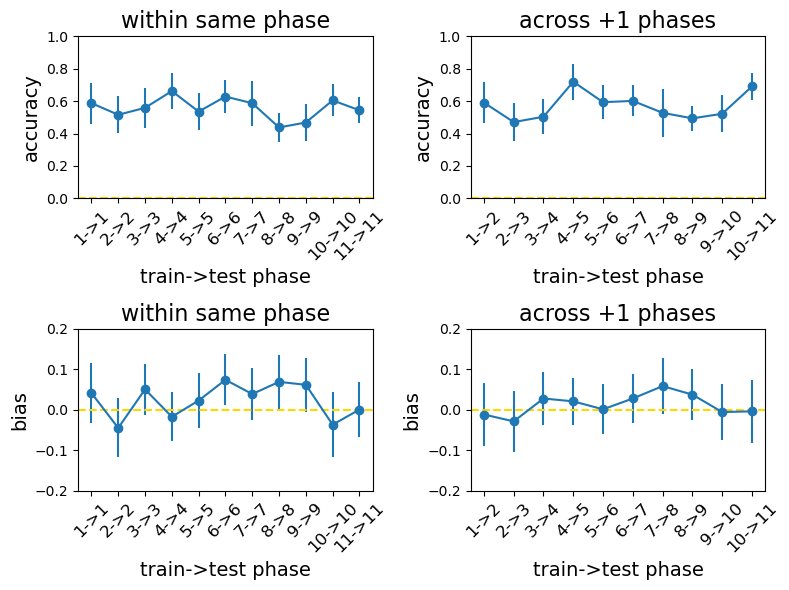

In [95]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    click_mem2_cross_phase_results, 'accuracy', 
    plot_settings, click_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'click_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

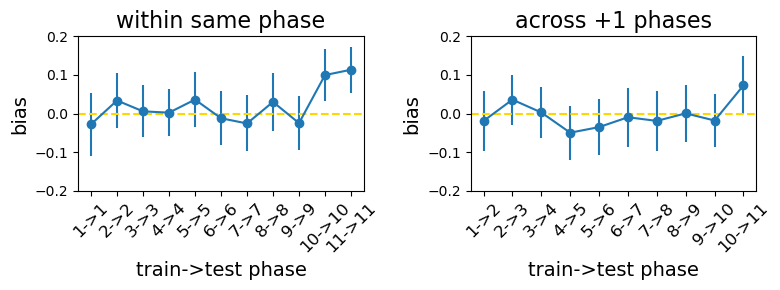

In [96]:
click_valid_both_prev_lmb = lambda df: (
    (df['mode'] == 'click').to_numpy() & both_has_prev_lmb(df))

plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    click_mem2_cross_phase_results, 'sd', 
    plot_settings, click_valid_both_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'click_delay_decoded_multi_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

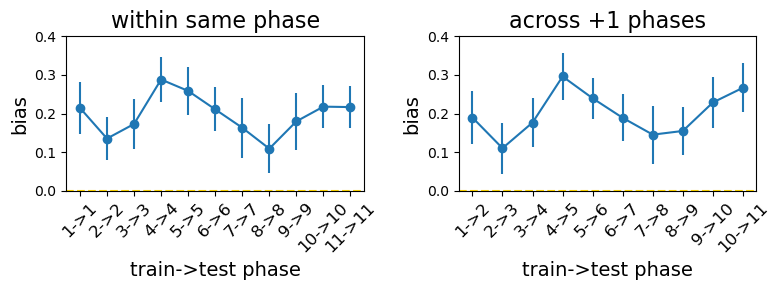

In [97]:
click_valid_both_prev_lmb = lambda df: (
    (df['mode'] == 'click').to_numpy() & both_has_prev_lmb(df))

plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    click_mem2_cross_phase_results, 'sur', 
    plot_settings, click_both_lmb,
    plot_ymin=0, plot_ymax=0.4)
plot_path = os.path.join(PLOTS_FOLDER, 'click_delay_decoded_multi_phases_sur_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

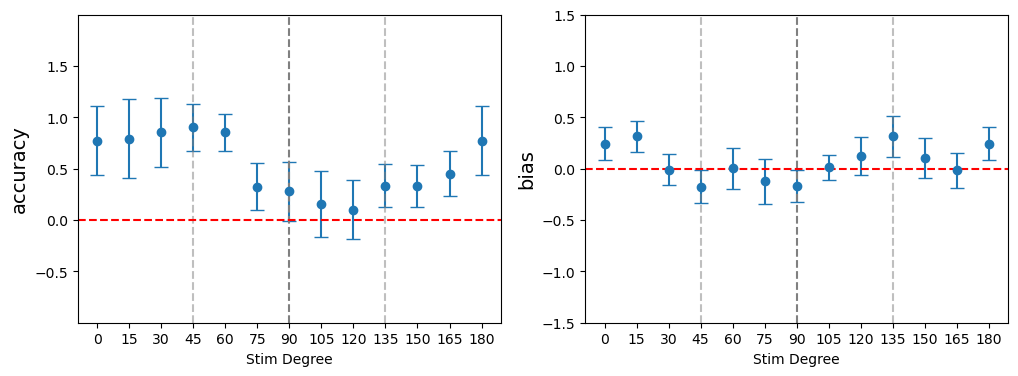

In [98]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][0],
    common_lmb=click_both_lmb, condition_name='click_first_phase')

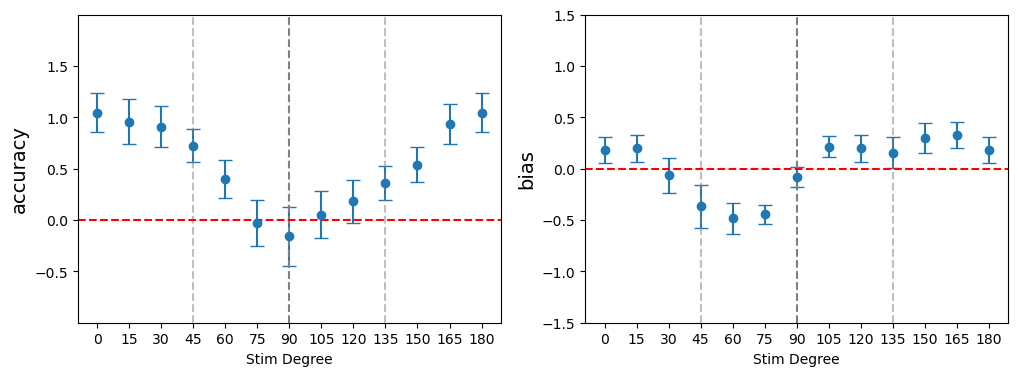

In [99]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][-1],
    common_lmb=click_both_lmb, condition_name='click_last_phase')

##### Also store the stats at the first and last phase of delay

In [100]:
mode_cross_phase_results = {
    'draw': draw_mem2_cross_phase_results,
    'click': click_mem2_cross_phase_results,
}

for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    for mode in ['draw', 'click']:
        test_lmb = mode_lmbs[mode]
        stat_extract_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': stim1_valid_lmb,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': stim2_valid_lmb,
            },
            'combined': {
                'target': 'combined',
                'lmb': None,
            },
        }

        results = mode_cross_phase_results[mode][0][phase_id]

        for stats_type in ['accuracy', 'sd', 'sur']:
            print(f'Saving {mode} {stats_type} stats')
            common_lmb = test_lmb
            if stats_type == 'sd':
                common_lmb = mode_prev_lmbs[mode]
            store_subject_stats(
                results, 
                common_lmb, 
                stat_extract_settings, 
                stats_type, 
                f'delay_{phase_name}_phase_{mode}2{mode}',
                item_weights_lmb=item_weights_lmb,
                sharpness=delay_best_sharpness)
        

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [101]:
for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    test_lmb = valid_both_lmb
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }

    results = mem2_cross_phase_results[0][phase_id]
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            results, 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'delay_{phase_name}_phase_combined',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
        

Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### When does draw and click start diverging?

In [102]:
def within_phase_cross_mode_train_test(phases, train_lmb, test_lmb):
    all_phase_steps = [0,]
    n_train_phases = len(phases)
    phases_results = [[] for _ in all_phase_steps]

    n_subjects = len(all_subjs)
    for train_id in tqdm(range(n_train_phases)):
        for phase_step in all_phase_steps:
            test_id = train_id + phase_step
            if test_id >= len(phases):
                continue
            # get results
            train_phase = phases[train_id]
            test_phase = phases[test_id]
            results = cv_train_test_invert_encoding(
                DEFAULT_FORWARD_MODEL_PARAMS, 
                train_phase, test_phase, 
                ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
                train_lmb, test_lmb, 
                item_weights_lmb, n_subjects, use_tqdm=False)
            phases_results[phase_step].append(results)

    return phases_results

In [103]:
within_phase_draw2click_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, draw_both_lmb, click_both_lmb)

100%|██████████| 11/11 [00:27<00:00,  2.46s/it]


In [104]:
within_phase_click2draw_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, click_both_lmb, draw_both_lmb)

100%|██████████| 11/11 [00:26<00:00,  2.45s/it]


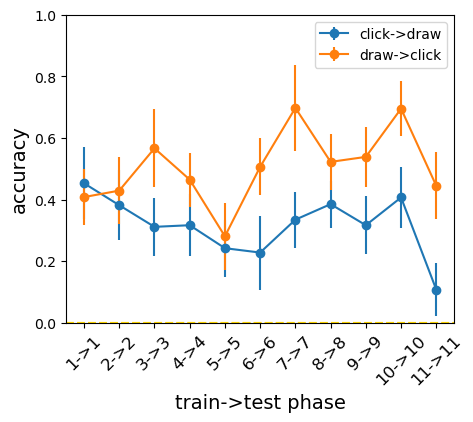

In [105]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


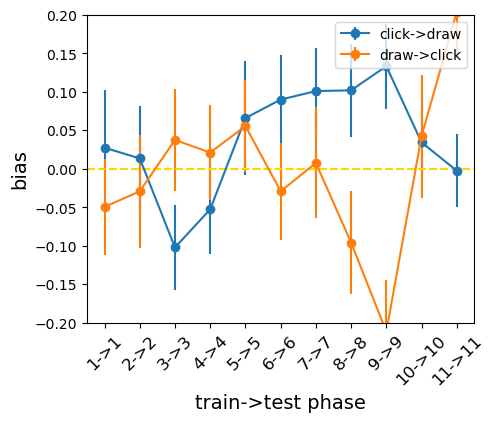

In [106]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_bias_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


##### Hypothesis: the gaze patterns 'evolve' over time, but differently for different modes

In [107]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

# phase 1-> 6, 6 -> 11, 1 -> 11
def show_over_delay_decoding_divergence(common_lmb):
    start_id = 0
    end_id = len(DELAY_WINDOWS) - 1
    mid1_id = len(DELAY_WINDOWS) // 3
    mid2_id = len(DELAY_WINDOWS) * 2 // 3


    phase_ids = [start_id, mid1_id, mid2_id, end_id]
    collected_results = {
        'phase_ids': phase_ids,
    }
    for stat_name in ['accuracy', 'bias']:
        for stype in ['mean', 'sem']:
            collected_results[f'{stat_name}_{stype}'] = np.zeros((len(phase_ids), len(phase_ids)))
            collected_results[f'{stat_name}_{stype}'].fill(np.nan)

    for train_id, test_id in zip(
            [0, 1, 2, 0, 1, 0],
            [1, 2, 3, 2, 3, 3]):
        train_phase = DELAY_WINDOWS[phase_ids[train_id]]
        test_phase = DELAY_WINDOWS[phase_ids[test_id]]
        results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            train_phase, test_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            common_lmb, common_lmb, 
            item_weights_lmb, n_subjects, use_tqdm=False)
        
        # compute accuracy
        stats = display_stats_and_distrib(
            None, results,
            stats_type='accuracy', 
            common_lmb=common_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        stats = stats['combined']
        print(f'==={train_id} -> {test_id}===')

        # formulate data
        for stat_name in ['accuracy', 'bias']:
            for stype in ['mean', 'sem']:
                collected_results[f'{stat_name}_{stype}'][train_id, test_id] = stats[stat_name][stype]

        print(f'accuracy: {stats["accuracy"]["mean"]:.3f} +/- {stats["accuracy"]["sem"]:.3f}')
        print(f'bias: {stats["bias"]["mean"]:.3f} +/- {stats["bias"]["sem"]:.3f}')

    return collected_results

def plot_cross_phase_evolve(ax, results, stat_name):
    phase_ids = results['phase_ids']
    mean_name = f'{stat_name}_mean'
    sem_name = f'{stat_name}_sem'
    mean_table = results[mean_name]
    sem_table = results[sem_name]

    color_level_maps = [
        'blue', 'green', 'red',]

    n_phases = len(mean_table) 
    for i in range(n_phases):
        for j in range(i+1, n_phases):
            if np.isnan(mean_table[i, j]):
                continue
            color = color_level_maps[j-i-1]
            ax.fill_between(
                [i, j], 
                mean_table[i, j] - sem_table[i, j], 
                mean_table[i, j] + sem_table[i, j], 
                alpha=0.2, color=color, linewidth=0)
            ax.plot(
                [i, j], [mean_table[i, j], mean_table[i, j]], 
                marker='o',
                color=color, linewidth=2)
            
    for i, phase_id in enumerate(phase_ids):
        ax.axvline(i, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xticks(np.arange(n_phases))
    ax.set_xticklabels(phase_ids)
    ax.set_xlabel('phases', fontsize=16)
    ylabel_name = 'generalizability' if stat_name == 'accuracy' else 'shift'
    ax.set_ylabel(ylabel_name, fontsize=16)


In [108]:
draw_cross_phase_evolve = show_over_delay_decoding_divergence(draw_both_lmb)

===0 -> 1===
accuracy: 0.345 +/- 0.104
bias: 0.044 +/- 0.062
===1 -> 2===
accuracy: 0.391 +/- 0.078
bias: 0.095 +/- 0.046
===2 -> 3===
accuracy: 0.367 +/- 0.109
bias: -0.003 +/- 0.043
===0 -> 2===
accuracy: 0.310 +/- 0.111
bias: 0.060 +/- 0.053
===1 -> 3===
accuracy: 0.320 +/- 0.077
bias: 0.184 +/- 0.039
===0 -> 3===
accuracy: 0.292 +/- 0.101
bias: 0.099 +/- 0.074


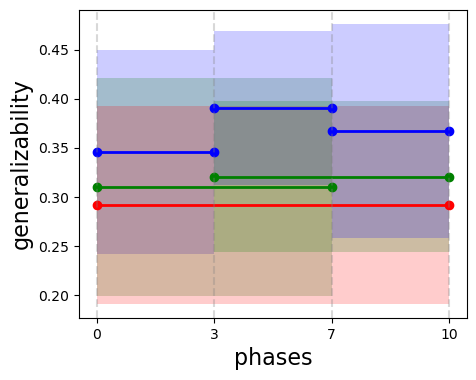

In [109]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, draw_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'draw_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

In [110]:
click_cross_phase_evolve = show_over_delay_decoding_divergence(click_both_lmb)

===0 -> 1===
accuracy: 0.549 +/- 0.115
bias: 0.067 +/- 0.061
===1 -> 2===
accuracy: 0.619 +/- 0.121
bias: 0.018 +/- 0.073
===2 -> 3===
accuracy: 0.536 +/- 0.085
bias: -0.000 +/- 0.074
===0 -> 2===
accuracy: 0.528 +/- 0.096
bias: 0.054 +/- 0.071
===1 -> 3===
accuracy: 0.616 +/- 0.123
bias: 0.028 +/- 0.064
===0 -> 3===
accuracy: 0.553 +/- 0.109
bias: 0.084 +/- 0.082


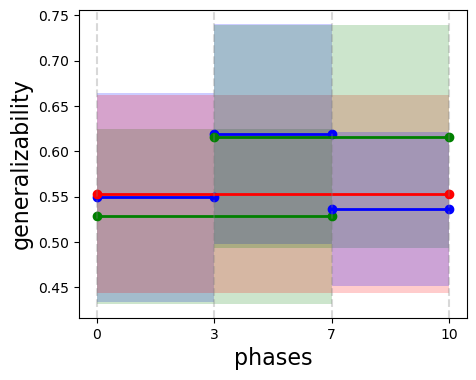

In [111]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, click_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'click_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

**comment**: ok hard to tell. But it seems for drawing there is a big shift in representation especially during the middle phase; in comparision, representation of clicking is more stable. This correspond to the self-reported strategy (from the prelimary study)

#### Lastly, switch to one memory load is 1

In [112]:
mem1_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_single_item_lmb)

100%|██████████| 11/11 [00:46<00:00,  4.23s/it]


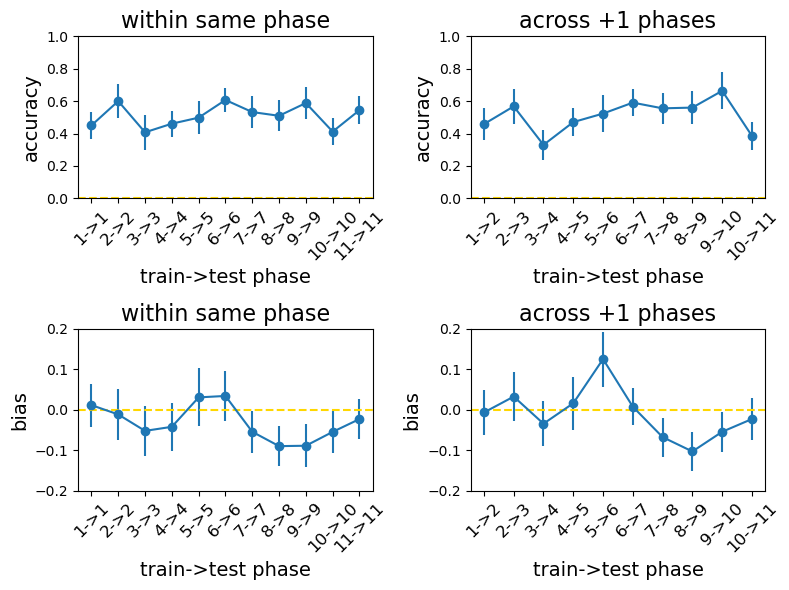

In [113]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'accuracy', 
    plot_settings, valid_single_item_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

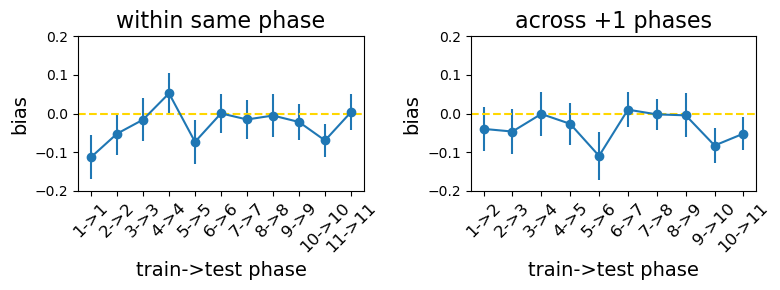

In [114]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'sd', 
    plot_settings, single_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

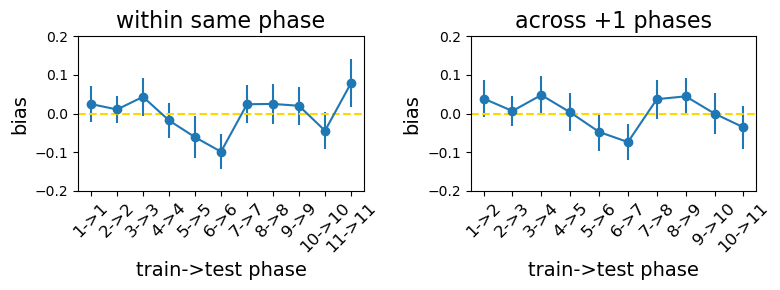

In [115]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'sur', 
    plot_settings, valid_single_item_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_sur_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

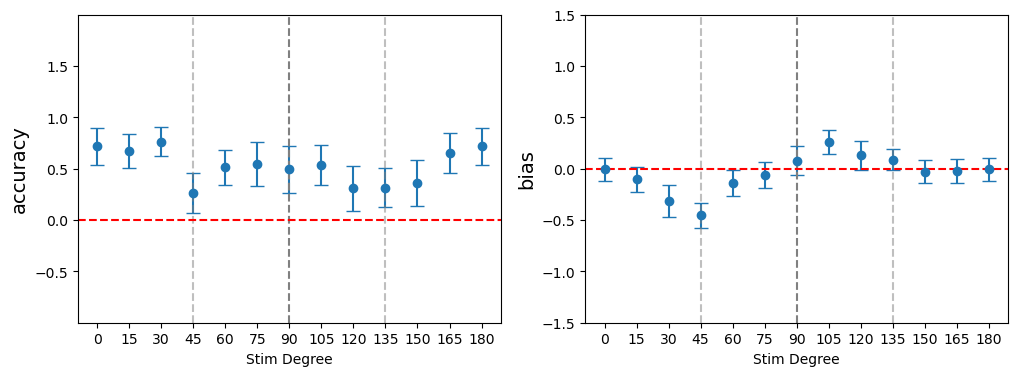

In [116]:
display_acc_bias_as_tuning(
    results=mem1_cross_phase_results[0][-1],
    common_lmb=valid_single_item_lmb, condition_name='last_phase_single')

##### Comment
But we can directly plot SURROUNDING bias for load=1. There is no significant bias though. Also there is no significant serial bias. All aligns with the behavior results.

#### Also store the decoded...

In [127]:
def compute_and_store_decoded_distrib(all_results, result_name, sharpness=delay_best_sharpness):
    all_result_path = os.path.join(PROCESSED_FOLDER, 'predictions', f'{result_name}')
    os.makedirs(all_result_path, exist_ok=True)

    # store data apply to the whole phase
    y_df_path = os.path.join(all_result_path, 'y_df.csv')
    ys_path = os.path.join(all_result_path, 'ys.npy')

    for tid, results in enumerate(all_results):
        # process the result at time t
        result_path = os.path.join(all_result_path, f'phase_{tid}')
        os.makedirs(result_path, exist_ok=True)

        y_pred_distrib = channel_weights_to_pseudo_distrib(
            results['preds'], delay_model, sharpness=sharpness)
        y_df = results['test_df'].reset_index(drop=True)
        ys = results['test_ys']

        # note that df have been shuffled so we need to correct the order...
        trial_orders = y_df['TRIALID'].argsort()
        y_df = y_df.iloc[trial_orders].reset_index(drop=True)
        ys = ys[trial_orders]
        y_pred_distrib = y_pred_distrib[trial_orders]

        # store the settings
        if tid == 0:
            y_df.to_csv(y_df_path, index=False)
            np.save(ys_path, ys)

        # store the raw predicted distribution
        y_pred_distrib_path = os.path.join(result_path, 'y_pred_distrib.npy')
        np.save(y_pred_distrib_path, y_pred_distrib)

        # store the aligned version
        aligned_path = os.path.join(result_path, 'aligned')
        os.makedirs(aligned_path, exist_ok=True)
        stim_names = ['stim_1', 'stim_2']
        for sid, stim_name in enumerate(stim_names):
            # specify the references to compare with
            stim_path = os.path.join(aligned_path, f'{stim_name}')
            os.makedirs(stim_path, exist_ok=True)
            ref_types = {
                'target': '',
                'nontarget': f'stim_{2-sid}',
                'previous': 'prev_last_response',
            }
            for ref_type in ref_types:
                ref_align_path = os.path.join(stim_path, f'{ref_type}.npy')
                ref_name = ref_types[ref_type]
                refs = None
                if ref_name:
                    refs = y_df[ref_name].to_numpy(copy=True)

                # save the aligned distribution and mask
                y_distrib, y_valid_mask = shift_align_distrib(
                    y_pred_distrib, ys[:, sid], refs=refs)
                y_distrib[~y_valid_mask] = np.nan
                np.save(ref_align_path, y_distrib)

In [128]:
compute_and_store_decoded_distrib(
    all_results=draw_mem2_cross_phase_results[0],
    result_name='draw_delay_phase',
    sharpness=delay_best_sharpness)

In [129]:
compute_and_store_decoded_distrib(
    all_results=click_mem2_cross_phase_results[0],
    result_name='click_delay_phase',
    sharpness=delay_best_sharpness)